## Entendendo os dados
Começamos carregando as bibliotecas de suporte para análise dos dados.

In [377]:
#libs
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Modelo
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import sensitivity_score, specificity_score
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import optuna
from sklearn.model_selection import cross_val_score
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from imblearn.metrics import sensitivity_score, specificity_score

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Configuração do Notebook
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None

Dados

In [378]:
df = pd.read_csv(r"customer_churn.csv")
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


In [379]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   int64 
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   int64 
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMethod 

In [380]:
def check_cols(data, columns):
    df_check = pd.DataFrame(zip(data[columns].dtypes.index, 
                                data[columns].dtypes, 
                                data[columns].nunique(), 
                                data[columns].isna().sum(),
                                round(data[columns].isna().sum()/data.shape[0], 3)*100), 
                            columns=['Variável', 'Tipo', 'Qtde_unicos', 'Qtde_NaN', '%_NaN'])
    return df_check.sort_values('Qtde_NaN').reset_index().drop('index', axis=1)

In [381]:
check_cols(df, df.columns)

,Variável,Tipo,Qtde_unicos,Qtde_NaN,%_NaN
0,customerID,object,7043,0,0.0
1,MonthlyCharges,object,1585,0,0.0
2,PaymentMethod,object,4,0,0.0
3,PaperlessBilling,object,2,0,0.0
4,Contract,object,3,0,0.0
5,StreamingMovies,object,3,0,0.0
6,StreamingTV,object,3,0,0.0
7,TechSupport,object,3,0,0.0
8,DeviceProtection,object,3,0,0.0
9,OnlineBackup,object,3,0,0.0


In [382]:
dados = df.copy()
dados.sample(7)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4455,6195-MELTI,Male,0,No,No,57,Yes,No,DSL,No,Yes,No,Yes,No,No,One year,Yes,Mailed check,"54,65","3134,7",No
927,2845-AFFTX,Male,1,Yes,No,41,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,"99,8","4259,3",Yes
5961,0936-NQLJU,Female,0,Yes,No,41,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),"20,65","875,55",No
430,5130-IEKQT,Male,1,No,No,25,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,No,Mailed check,"105,95","2655,25",Yes
1497,7710-JSYOA,Female,0,Yes,Yes,69,Yes,Yes,Fiber optic,No,Yes,No,Yes,No,Yes,Two year,Yes,Bank transfer (automatic),"93,3","6398,05",No
608,9168-INPSZ,Female,1,Yes,No,44,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,No,Electronic check,"104,15","4495,65",No
5668,6096-EGVTU,Female,0,Yes,Yes,64,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,"24,9","1595,5",No


Tranformaçoes nos dadsos para leitura deles.

In [383]:
def value_counts_categoricas(df):
    """
    Mostra os value_counts de todas as colunas com 2, 3 ou 4 valores únicoscomproporção
    """
    # Seleciona colunas com até 4 valores únicos
    cols_categoricas = [col for col in df.columns if df[col].nunique() in [2, 3, 4]]
    
    print(f"📋 {len(cols_categoricas)} colunas categóricas selecionadas: {cols_categoricas}\n")
    
    # Exibe value_counts para cada uma
    for col in cols_categoricas:
        print(f"\n🔹 Coluna: {col} ({df[col].nunique()} valores únicos)")
        display(
            df[col].value_counts(dropna=False, normalize=False)
            .to_frame('Contagem')
            .assign(Proporção=lambda x: round(x['Contagem'] / x['Contagem'].sum() * 100, 2))
        )


value_counts_categoricas(df)

📋 17 colunas categóricas selecionadas: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


🔹 Coluna: gender (2 valores únicos)


,Contagem,Proporção
gender,,
Male,3555,50.48
Female,3488,49.52



🔹 Coluna: SeniorCitizen (2 valores únicos)


,Contagem,Proporção
SeniorCitizen,,
0,5901,83.79
1,1142,16.21



🔹 Coluna: Partner (2 valores únicos)


,Contagem,Proporção
Partner,,
No,3641,51.7
Yes,3402,48.3



🔹 Coluna: Dependents (2 valores únicos)


,Contagem,Proporção
Dependents,,
No,4933,70.04
Yes,2110,29.96



🔹 Coluna: PhoneService (2 valores únicos)


,Contagem,Proporção
PhoneService,,
Yes,6361,90.32
No,682,9.68



🔹 Coluna: MultipleLines (3 valores únicos)


,Contagem,Proporção
MultipleLines,,
No,3390,48.13
Yes,2971,42.18
No phone service,682,9.68



🔹 Coluna: InternetService (3 valores únicos)


,Contagem,Proporção
InternetService,,
Fiber optic,3096,43.96
DSL,2421,34.37
No,1526,21.67



🔹 Coluna: OnlineSecurity (3 valores únicos)


,Contagem,Proporção
OnlineSecurity,,
No,3498,49.67
Yes,2019,28.67
No internet service,1526,21.67



🔹 Coluna: OnlineBackup (3 valores únicos)


,Contagem,Proporção
OnlineBackup,,
No,3088,43.84
Yes,2429,34.49
No internet service,1526,21.67



🔹 Coluna: DeviceProtection (3 valores únicos)


,Contagem,Proporção
DeviceProtection,,
No,3095,43.94
Yes,2422,34.39
No internet service,1526,21.67



🔹 Coluna: TechSupport (3 valores únicos)


,Contagem,Proporção
TechSupport,,
No,3473,49.31
Yes,2044,29.02
No internet service,1526,21.67



🔹 Coluna: StreamingTV (3 valores únicos)


,Contagem,Proporção
StreamingTV,,
No,2810,39.90
Yes,2707,38.44
No internet service,1526,21.67



🔹 Coluna: StreamingMovies (3 valores únicos)


,Contagem,Proporção
StreamingMovies,,
No,2785,39.54
Yes,2732,38.79
No internet service,1526,21.67



🔹 Coluna: Contract (3 valores únicos)


,Contagem,Proporção
Contract,,
Month-to-month,3875,55.02
Two year,1695,24.07
One year,1473,20.91



🔹 Coluna: PaperlessBilling (2 valores únicos)


,Contagem,Proporção
PaperlessBilling,,
Yes,4171,59.22
No,2872,40.78



🔹 Coluna: PaymentMethod (4 valores únicos)


,Contagem,Proporção
PaymentMethod,,
Electronic check,2365,33.58
Mailed check,1612,22.89
Bank transfer (automatic),1544,21.92
Credit card (automatic),1522,21.61



🔹 Coluna: Churn (2 valores únicos)


,Contagem,Proporção
Churn,,
No,5174,73.46
Yes,1869,26.54


In [384]:
# Churn é sempre binária (Yes/No)
dados['Churn'] = dados['Churn'].map({'Yes': True, 'No': False})

# Colunas de serviços com até 2 valores únicos -> podemos mapear para bool
bool_cols_binarias = [
    'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling'
]

for col in bool_cols_binarias:
    dados[col] = dados[col].map({'Yes': True, 'No': False})

# Colunas com 3 categorias — mantêm os 3 valores (ex: Yes, No, No internet service)

# Corrigir separador decimal nas colunas numéricas
dados['MonthlyCharges'] = dados['MonthlyCharges'].astype(str).str.replace(',', '.').astype(float)
dados['TotalCharges'] = dados['TotalCharges'].astype(str).str.replace(',', '.').astype(float)

# Manter os 3 valores nas colunas de múltiplas linhas e internet
dados['MultipleLines'] = dados['MultipleLines'].replace({
    'No phone service': 'No phone service',
    'No': 'No',
    'Yes': 'Yes'
})

dados['InternetService'] = dados['InternetService'].replace({
    'Fiber optic': 'Fiber',
    'DSL': 'DSL',
    'No': 'No internet service'
})

# Categorias contratuais padronizadas
dados['Contract'] = dados['Contract'].replace({
    'Month-to-month': 'Monthly',
    'One year': 'Annual',
    'Two year': 'Biennial'
})

# Classificação por tempo de contrato
def classify_tenure(tenure):
    if tenure <= 12:
        return 'Classe_00_12'
    elif tenure <= 24:
        return 'Classe_12_24'
    elif tenure <= 48:
        return 'Classe_24_48'
    elif tenure <= 60:
        return 'Classe_48_60'
    else:
        return 'Classe_60_99'

dados['ClasseTempoContrato'] = dados['tenure'].apply(classify_tenure)

# Exibir uma amostra para verificar
print(dados.sample(7))

      customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
5731  9648-BCHKM  Female              0     True        True      18   
4596  4109-CYRBD    Male              1     True       False      29   
6960  9374-YOLBJ  Female              0     True        True       1   
1188  4647-MUZON  Female              0     True       False      18   
4803  4065-JJAVA  Female              0    False       False       1   
15    0017-IUDMW  Female              0     True        True      72   
2352  9812-GHVRI  Female              0    False       False      40   

      PhoneService MultipleLines      InternetService       OnlineSecurity  \
5731          True           Yes  No internet service  No internet service   
4596          True           Yes                  DSL                   No   
6960          True            No  No internet service  No internet service   
1188          True            No                Fiber                   No   
4803          True            No 

In [385]:
# separando as variaveis para fazer graficos
cat_vars = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling'
]

num_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

cat_vars_2 = cat_vars + ['PaymentMethod', 'ClasseTempoContrato']  


Para analisarmos os dados, podemos separar entre os consumidores que ficaram (Churn = False) e que saíram (Churn = True) no histórico.

In [386]:
dados.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ClasseTempoContrato
0,7569-NMZYQ,Female,0,True,True,72,True,Yes,Fiber,Yes,Yes,Yes,Yes,Yes,Yes,Biennial,True,Bank transfer (automatic),118.75,8672.45,False,Classe_60_99


In [387]:
resumo_churn = []
resumo_nao_churn = []

# Loop pelas variáveis categóricas
for col in cat_vars:
    # Churn = True
    proporcoes_true = dados.loc[dados.Churn, col].value_counts(normalize=True)
    for categoria, proporcao in proporcoes_true.items():
        resumo_churn.append({
            'Variavel': col,
            'Categoria': categoria,
            'Proporcao_Churn_True': round(proporcao * 100, 2)
        })
    
    # Churn = False
    proporcoes_false = dados.loc[~dados.Churn, col].value_counts(normalize=True)
    for categoria, proporcao in proporcoes_false.items():
        resumo_nao_churn.append({
            'Variavel': col,
            'Categoria': categoria,
            'Proporcao_Churn_False': round(proporcao * 100, 2)
        })

# Converte em DataFrames
resumo_churn = pd.DataFrame(resumo_churn)
resumo_nao_churn = pd.DataFrame(resumo_nao_churn)

# # Faz merge dos dois resumos
# resumo_churn_df = pd.merge(
#     df_churn_false,
#     df_churn_true,
#     on=['Variavel', 'Categoria'],
#     how='outer'
# ).fillna(0)

# Exibe resultado final
display(resumo_churn.head())
display(resumo_nao_churn.head())

,Variavel,Categoria,Proporcao_Churn_True
0,gender,Female,50.24
1,gender,Male,49.76
2,SeniorCitizen,0,74.53
3,SeniorCitizen,1,25.47
4,Partner,False,64.21


,Variavel,Categoria,Proporcao_Churn_False
0,gender,Male,50.73
1,gender,Female,49.27
2,SeniorCitizen,0,87.13
3,SeniorCitizen,1,12.87
4,Partner,True,52.82


In [388]:
resumo_cat = pd.concat([resumo_churn, resumo_nao_churn], axis = 1)
resumo_cat.sample(5)

,Variavel,Categoria,Proporcao_Churn_True,Variavel,Categoria,Proporcao_Churn_False
4,Partner,False,64.21,Partner,True,52.82
33,StreamingMovies,No internet service,6.05,StreamingMovies,No internet service,27.31
11,MultipleLines,No,45.43,MultipleLines,Yes,40.99
36,Contract,Biennial,2.57,Contract,Annual,25.26
15,InternetService,No internet service,6.05,InternetService,No internet service,27.31


In [389]:
dados.groupby('Churn').describe().T

Churn                       False        True 
SeniorCitizen  count  5174.000000  1869.000000
               mean      0.128721     0.254682
               std       0.334923     0.435799
               min       0.000000     0.000000
               25%       0.000000     0.000000
               50%       0.000000     0.000000
               75%       0.000000     1.000000
               max       1.000000     1.000000
tenure         count  5174.000000  1869.000000
               mean     37.569965    17.979133
               std      24.113777    19.531123
               min       0.000000     1.000000
               25%      15.000000     2.000000
               50%      38.000000    10.000000
               75%      61.000000    29.000000
               max      72.000000    72.000000
MonthlyCharges count  5174.000000  1869.000000
               mean     61.265124    74.441332
               std      31.092648    24.666053
               min      18.250000    18.850000
               25%      25.100000    56.150000
               50%      64.425000    79.650000
               75%      88.400000    94.200000
               max     118.750000   118.350000
TotalCharges   count  5163.000000  1869.000000
               mean   2555.344141  1531.796094
               std    2329.456984  1890.822994
               min      18.800000    18.850000
               25%     577.825000   134.500000
               50%    1683.600000   703.550000
               75%    4264.125000  2331.300000
               max    8672.450000  8684.800000

1. Tempo de Contrato (Tenure)

Clientes que não churnaram (Churn = False):
Média: 37,57 meses (~3 anos e 1 mês). Clientes fiéis permanecem mais tempo com a empresa, demonstrando maior estabilidade contratual.
Mediana: 38 meses. Metade dos clientes fiéis mantém o contrato por mais de 3 anos.
Distribuição: 25% possuem menos de 15 meses, enquanto 75% ultrapassam 61 meses de contrato.
Desvio Padrão (STD): 24,11 meses — indica alta dispersão, ou seja, há clientes muito recentes e outros com longa permanência.

A ampla variância mostra uma base de clientes heterogênea em termos de fidelização. Clientes de longo prazo são mais propensos à retenção.
Clientes que churnaram (Churn = True):
Média: 17,98 meses (~1 ano e meio). Esses clientes permanecem bem menos tempo antes de cancelar.
Mediana: 10 meses — metade deles deixa a empresa antes de completar 1 ano.
Distribuição: 25% têm menos de 2 meses de contrato.
Desvio Padrão (STD): 19,53 meses — a variação é menor que entre os fiéis, concentrando-se em períodos curtos.

Contratos mais curtos estão fortemente correlacionados com maior probabilidade de churn.

2. Custo Mensal (Monthly Charges)

Clientes que não churnaram (Churn = False):
Média: $61,27. Clientes fiéis tendem a pagar valores mensais mais baixos.
Mediana: $64,43.
Intervalo interquartil: 25% dos clientes pagam menos de $25,10, e 75% pagam menos de $88,40.
Desvio Padrão: $31,09 — alto, indicando ampla diversidade de planos e serviços.

Os clientes retidos costumam estar em faixas de custo moderadas, com forte variação associada a pacotes adicionais.
Clientes que churnaram (Churn = True):
Média: $74,44, significativamente mais alta que a dos clientes fiéis.
Mediana: $79,65.
Distribuição: 25% pagam acima de $94,20 mensais.
Desvio Padrão: $24,67 — menor dispersão, ou seja, a maioria desses clientes paga valores elevados dentro de uma faixa relativamente estreita.

Clientes com custos mensais mais altos apresentam maior propensão ao churn, possivelmente por percepção de menor custo-benefício.

3. Custo Total (Total Charges)

Clientes que não churnaram (Churn = False):
Média: $2.555,34 — esses clientes geram maior receita acumulada por permanecerem mais tempo.
Mediana: $1.683,60.
Distribuição: 25% dos clientes acumulam mais de $4.264,13 em pagamentos totais.
Desvio Padrão: $2.329,46, indicando alta variação — alguns clientes geram receitas superiores a $8.600, enquanto outros contribuem pouco.

A receita acumulada é fortemente associada à retenção: quanto maior o tempo de contrato, maior o valor total pago.

Clientes que churnaram (Churn = True):
Média: $1.531,80 — significativamente menor devido à curta duração do vínculo.
Mediana: $703,55.
Distribuição: 75% geram menos de $2.331,30 em receita total.
Desvio Padrão: $1.890,82 — embora existam clientes com altos custos, a maioria cancela antes de acumular grandes valores.

O churn está fortemente relacionado a baixos custos totais e contratos curtos.
Estratégias de retenção devem focar nos primeiros 10 a 12 meses, com:

- Incentivos de fidelidade.
- Suporte proativo no início do contrato.
- Ofertas customizadas para reduzir cancelamentos precoces.

Embora estas tabelas sejam interessantes, elas oferecem pouca informação detalhada sobre as alavancas de negócio e são de difícil interpretação. Podemos então complementar nossa análise com uma análise gráfica.

## Análise Gráfica Exploratória

In [326]:
a3data_colors = [
    
    "#0072CE",  
    "#E6007E",
    "#00205B"  
]

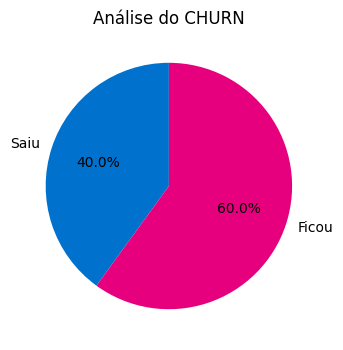

In [327]:
labels = ['Saiu', 'Ficou']  
values = [40, 60]  

plt.figure(figsize=(6, 4))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=a3data_colors[:len(values)])
plt.title('Análise do CHURN')

plt.show()


### Análise de Variáveis Categóricas

In [399]:
def compare_pie(data_churn, data_no_churn, variable, title_churn, title_no_churn, size=(None, 400)):
    churn_counts = data_churn[variable].value_counts()
    no_churn_counts = data_no_churn[variable].value_counts()

    labels = churn_counts.index.tolist()  # Assume rótulos iguais para ambos
    values_churn = churn_counts.values
    values_no_churn = no_churn_counts.values

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Gráficos lado a lado

    axes[0].pie(values_churn, labels=labels, autopct='%1.1f%%', startangle=90, colors=a3data_colors[:len(values_churn)])
    axes[0].set_title(title_churn)

    axes[1].pie(values_no_churn, labels=labels, autopct='%1.1f%%', startangle=90, colors=a3data_colors[:len(values_no_churn)])
    axes[1].set_title(title_no_churn)

    plt.suptitle(f"Comparação de {variable} - {title_churn} vs {title_no_churn}", fontsize=14)
    plt.tight_layout()
    plt.show()

def compare_bar(data_churn, data_no_churn, variable, title):
    churn_counts = data_churn[variable].value_counts(normalize=True) * 100  
    no_churn_counts = data_no_churn[variable].value_counts(normalize=True) * 100 

    comparison_df = pd.DataFrame({
        "Saiu (%)": churn_counts,
        "Ficou (%)": no_churn_counts
    }).fillna(0)

    comparison_df.plot(kind="bar", figsize=(10, 6), color=a3data_colors)
    plt.title(f"Comparação de {title} - Saiu vs Ficou", fontsize=14)
    plt.ylabel("Porcentagem (%)")
    plt.xlabel(variable)
    plt.xticks(rotation=45)
    plt.legend(title="Status do Cliente")
    plt.tight_layout()
    plt.show()

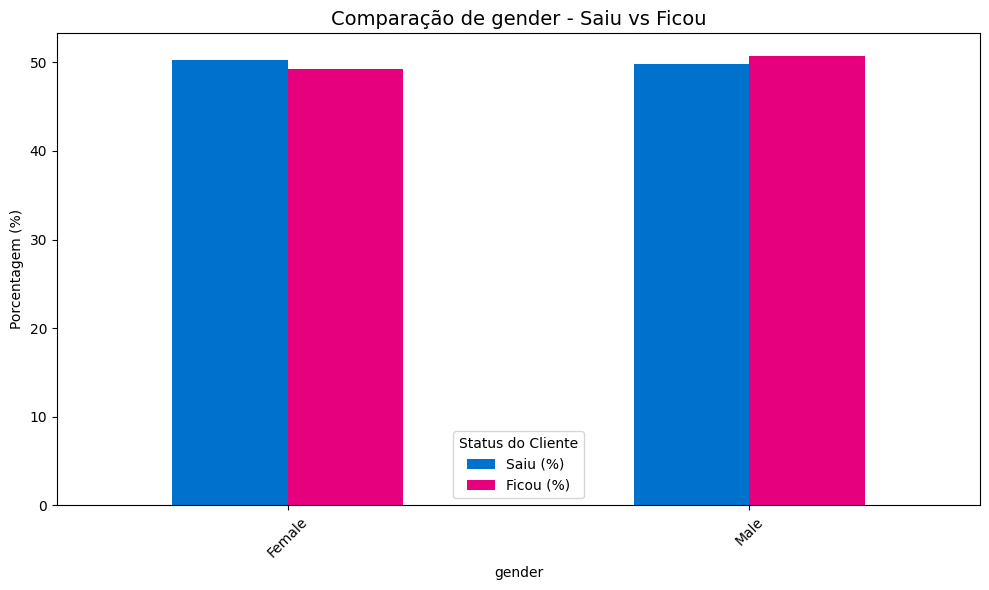

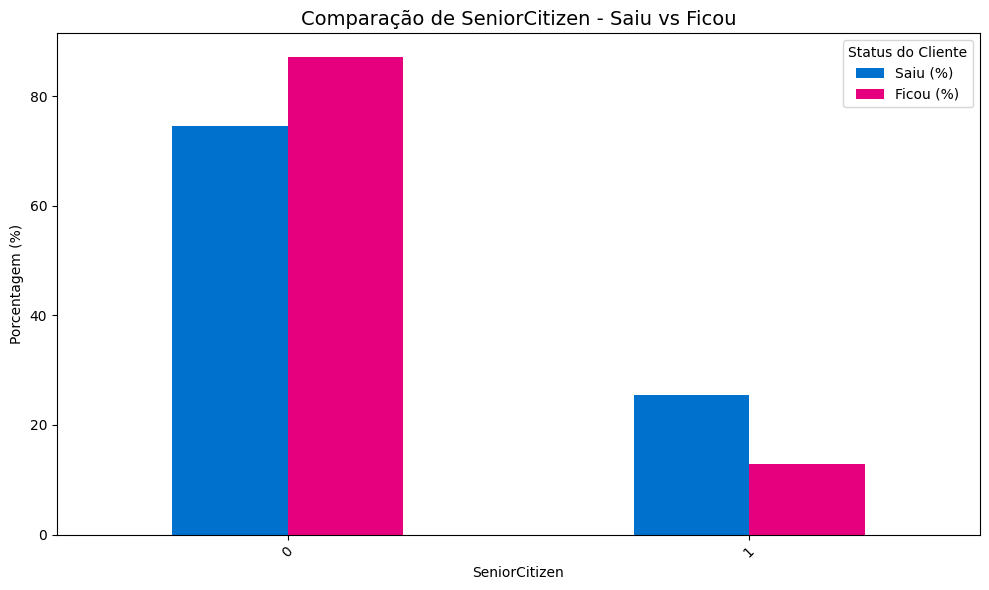

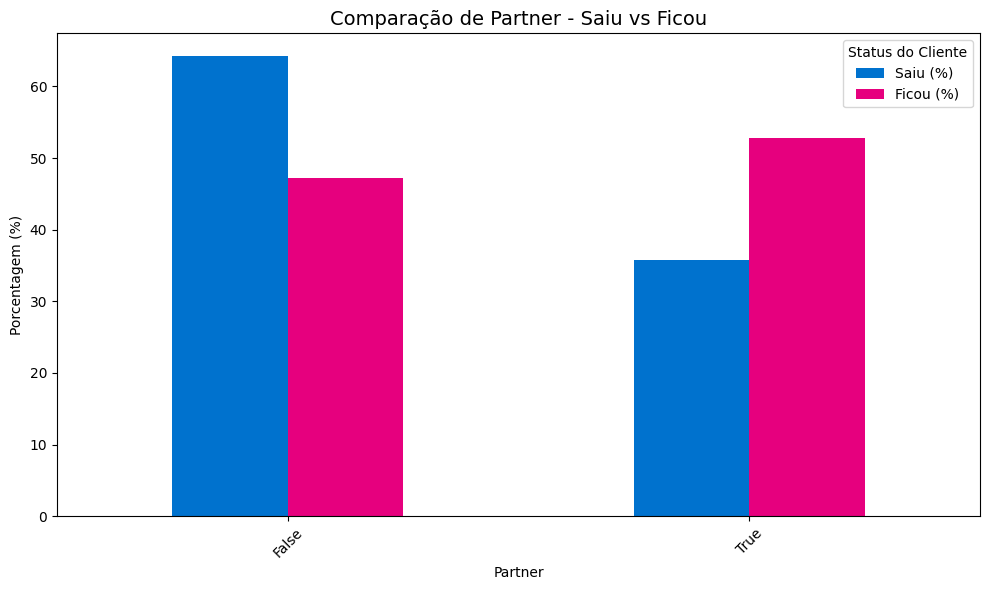

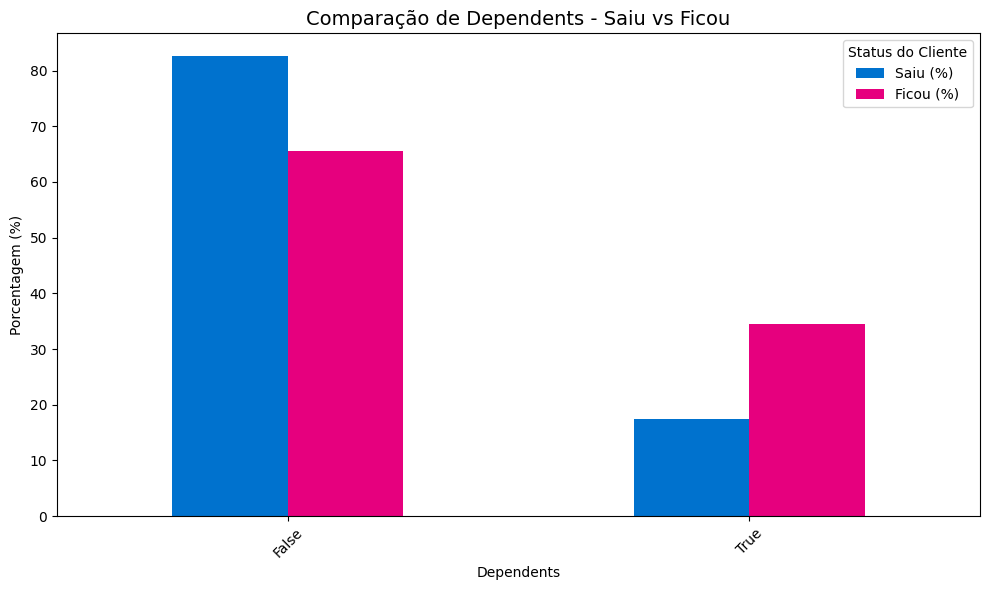

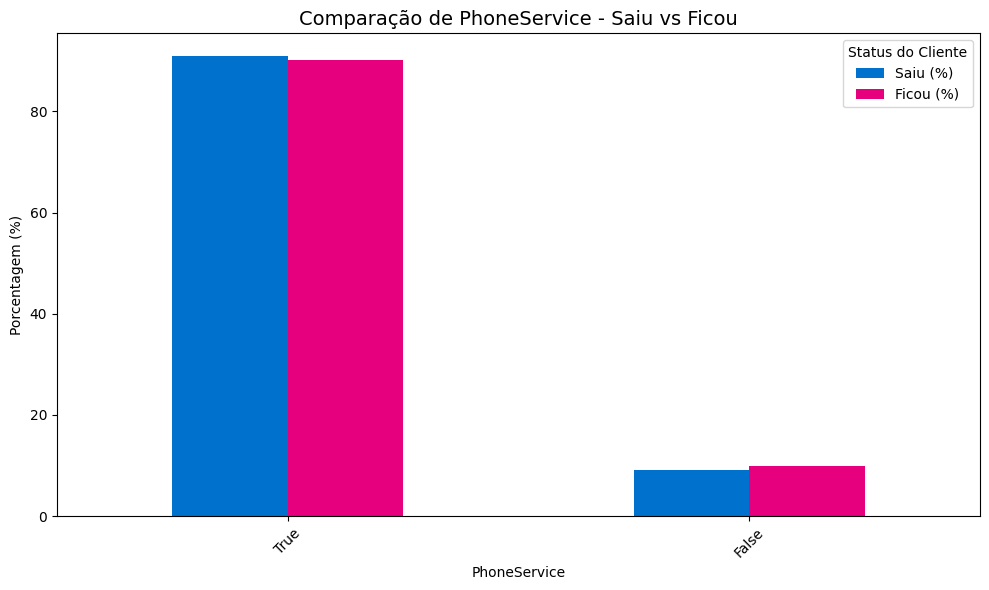

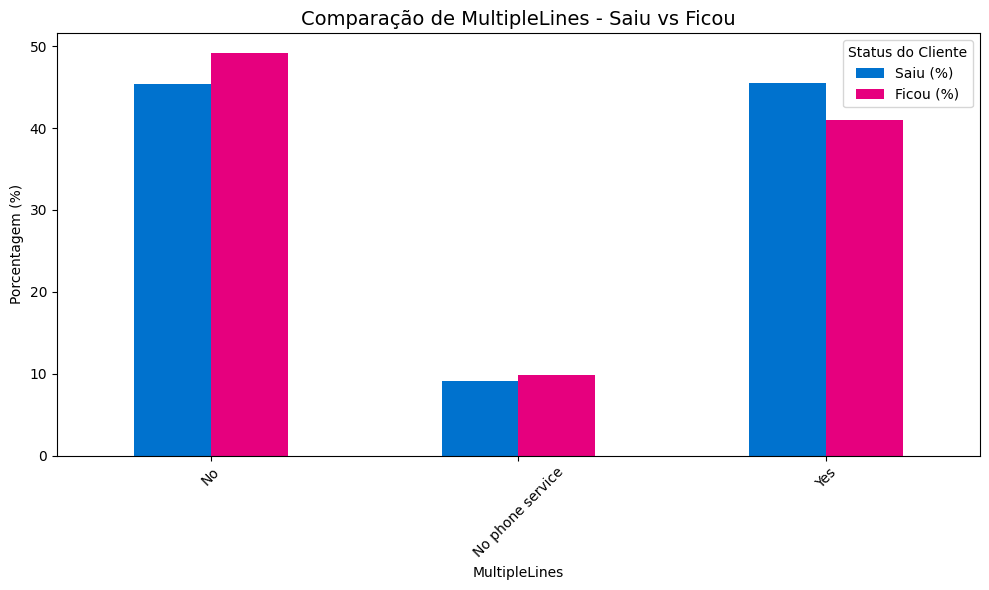

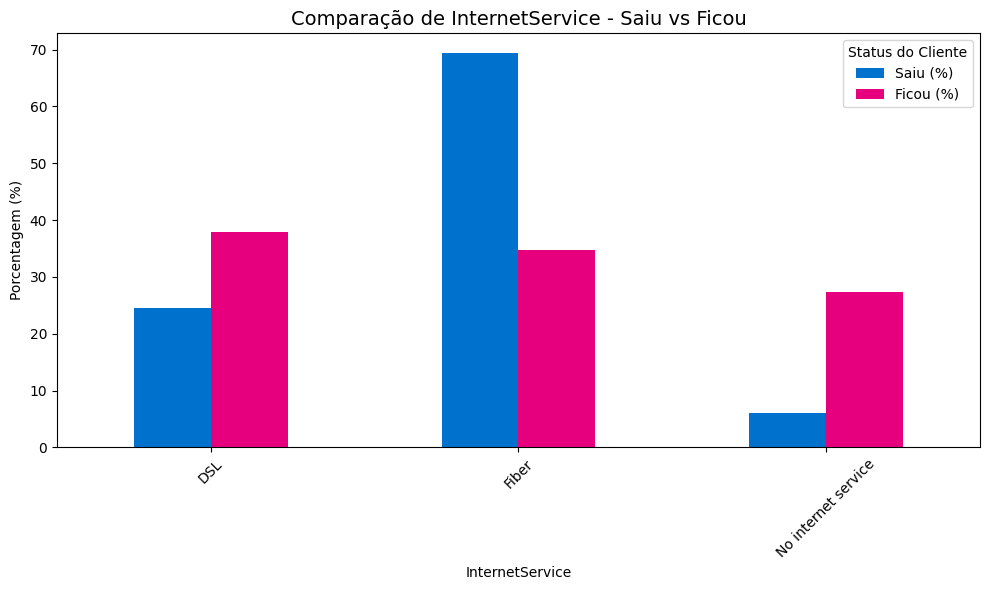

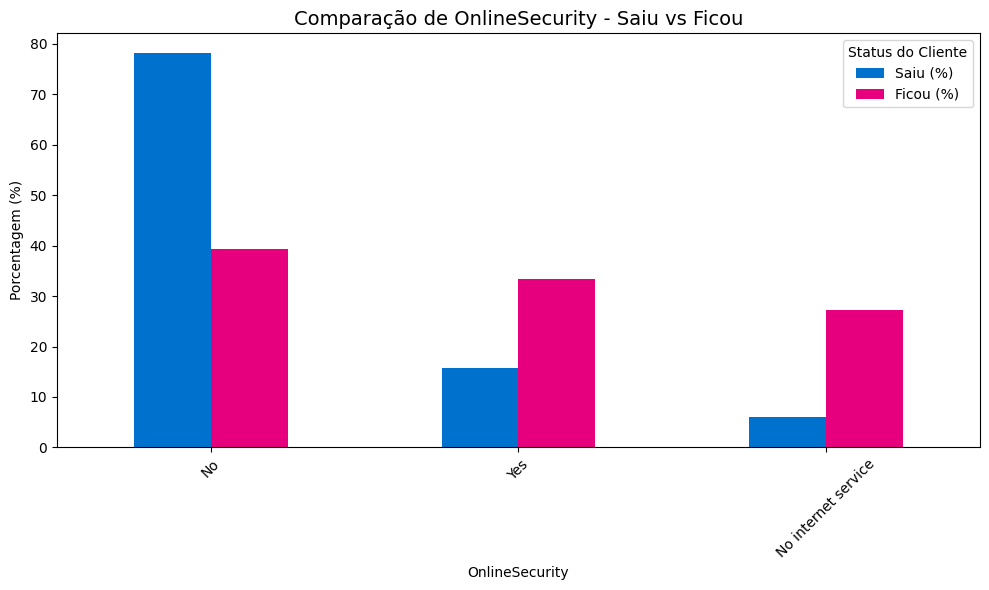

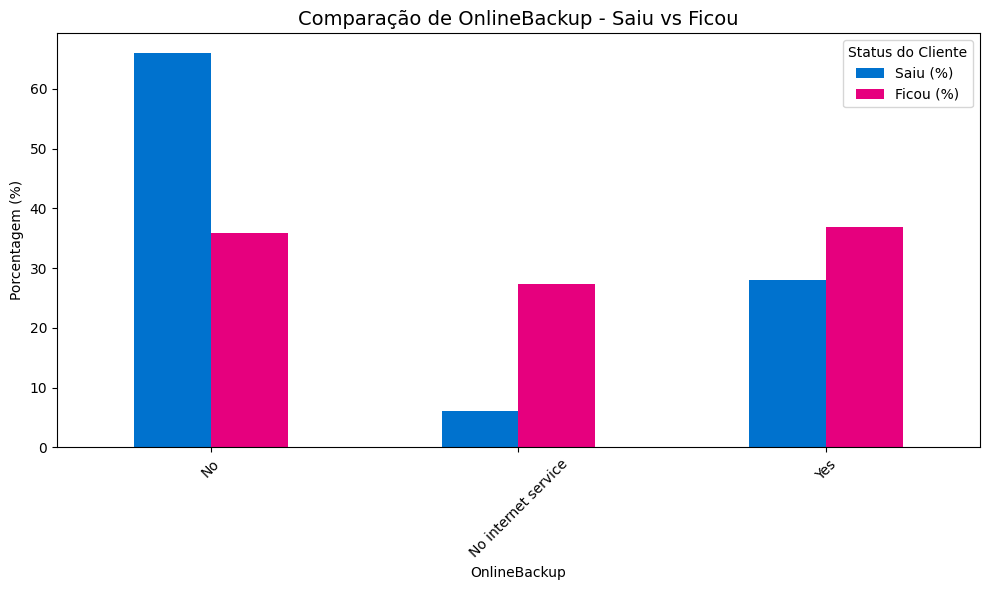

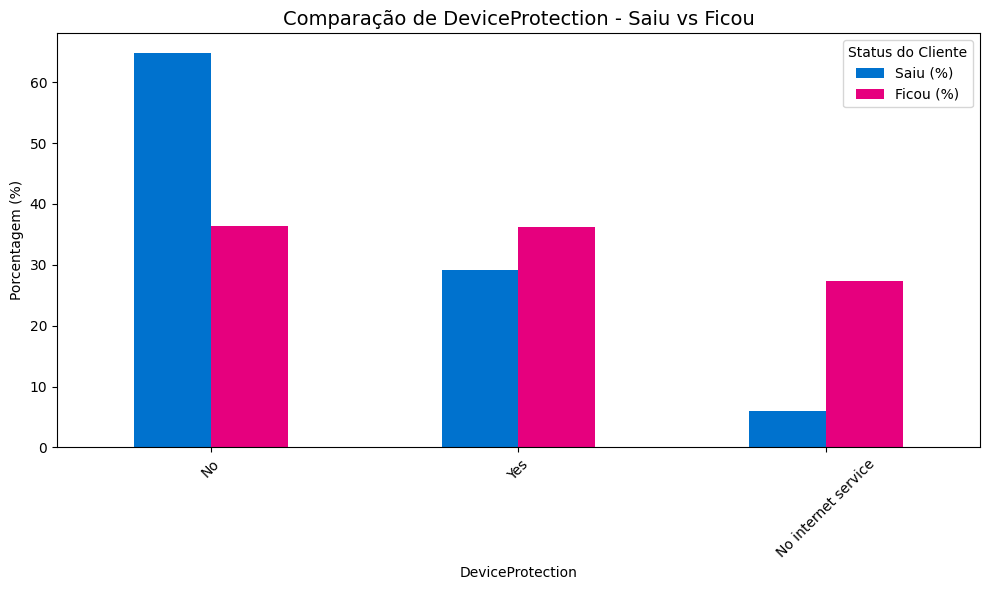

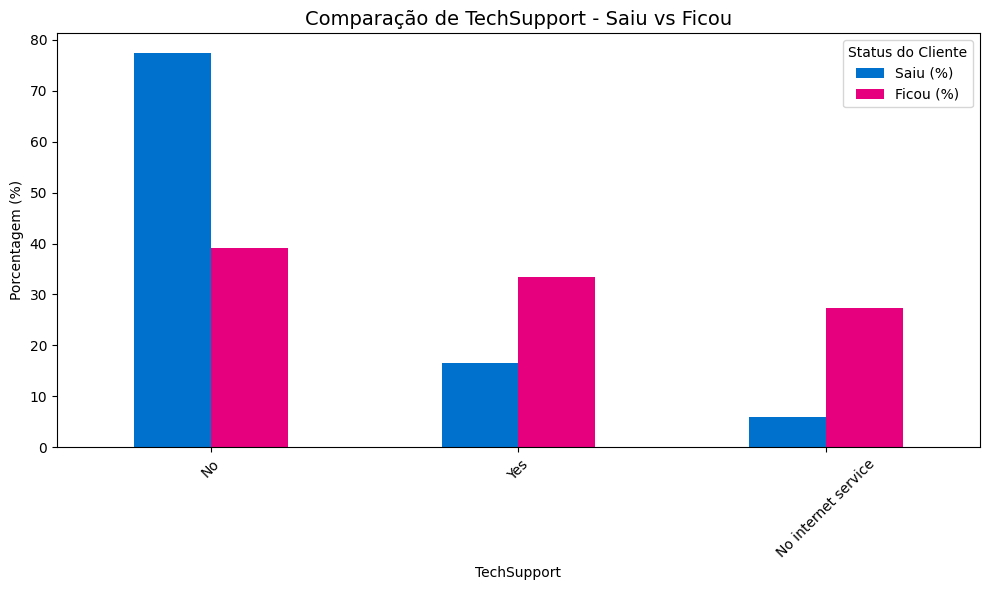

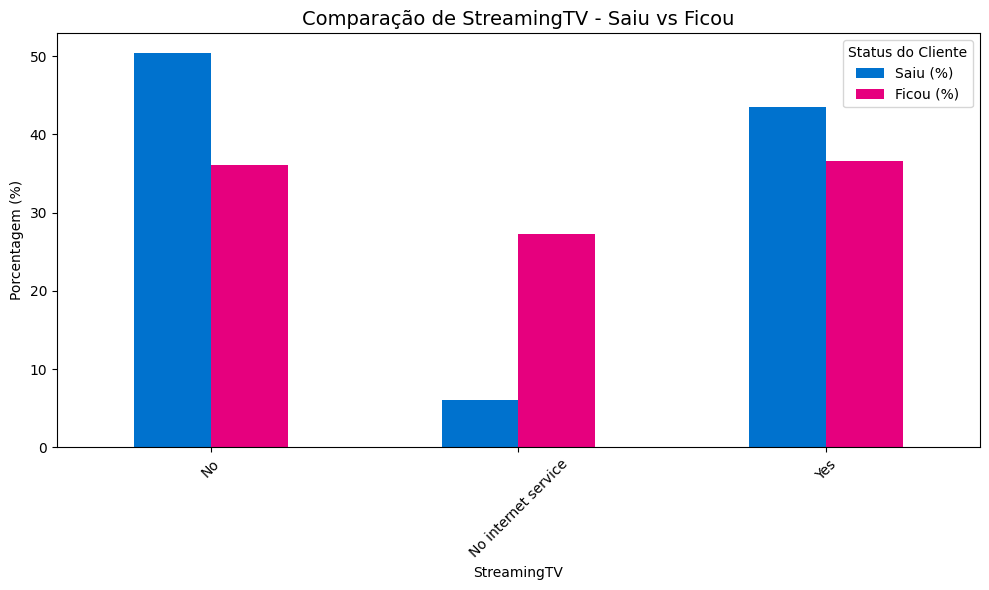

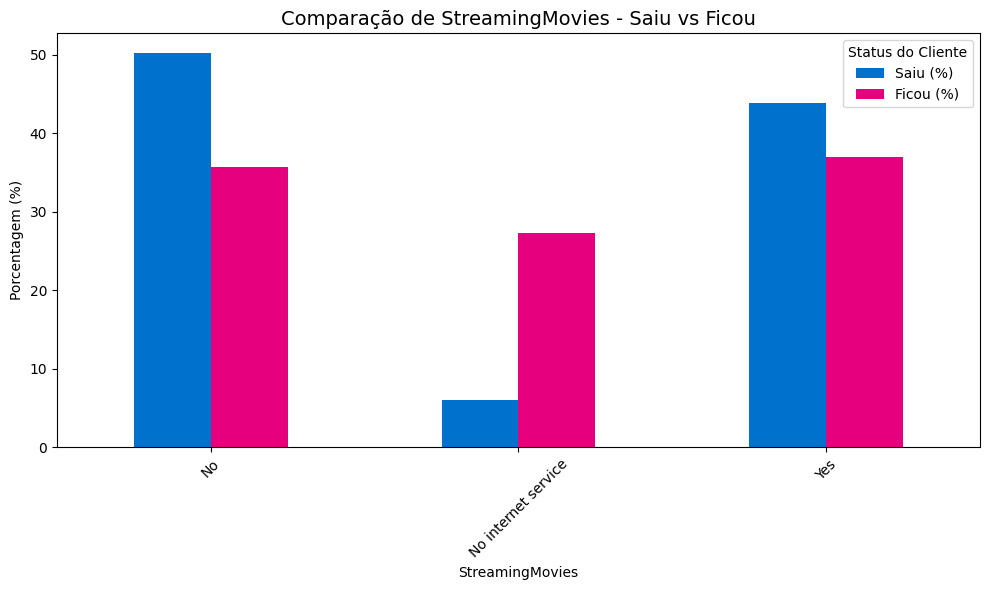

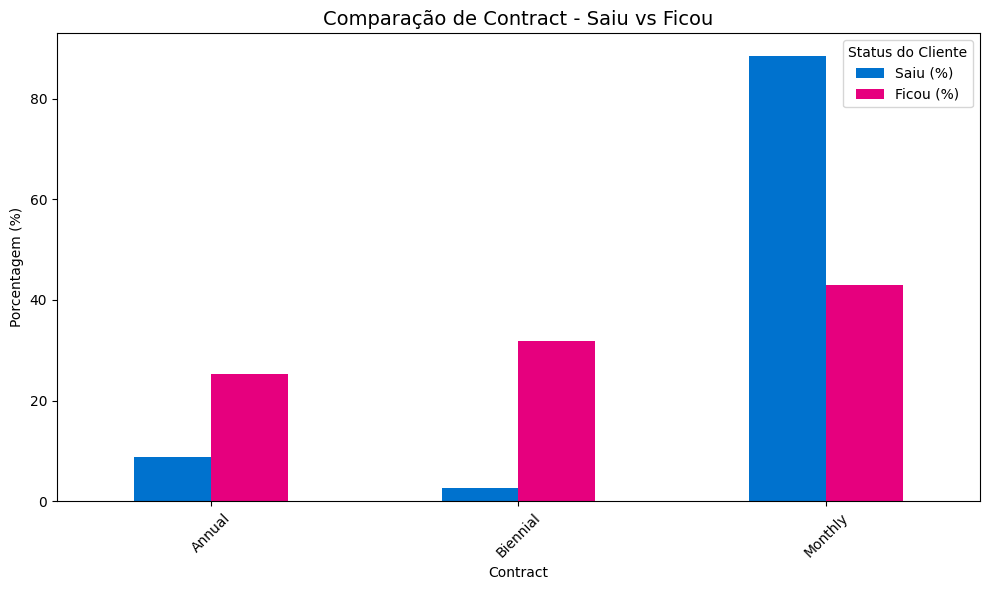

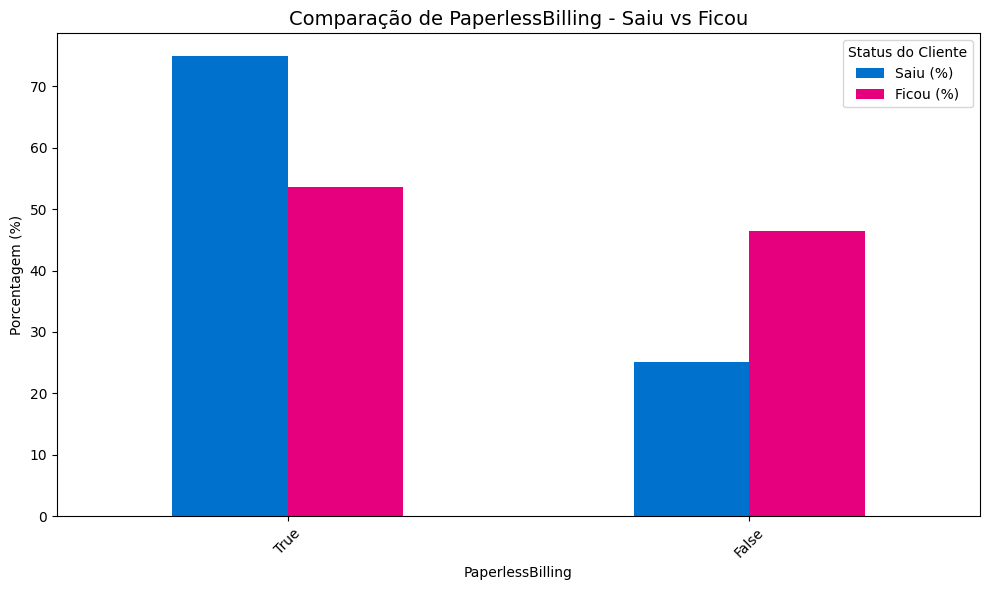

In [401]:
for var in cat_vars:
    compare_bar(dados[dados['Churn'] == 1], dados[dados['Churn'] == 0], var, var)

O publico feminino apresenta maior propenção a sair, porém esse numero nao é estatisticamente relevante nesse caso. </br>
Pessoas casadas costumam ficar mais tempo que pessoas nao casadas, assim como pessoas que declaram ter dependentes</br>
Pessoas que possuem fibra otima (internet) sao maioria na base dos clientes que sairam, enquanto clientes sem internet apresentam 27% dos clientes fieis.</br>
Pessoas que sairam tiveram menos suporte do que pessoas que ficaram.</br>
Clientes que possuem contrato mensal sao a maioria na massa de clientes que sairam. Já na massa de clientes que ficaram, os percentuais entre os contratos é mais equilibrado.</br>

In [330]:
dados.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ClasseTempoContrato
0,7569-NMZYQ,Female,0,True,True,72,True,Yes,Fiber,Yes,Yes,Yes,Yes,Yes,Yes,Biennial,True,Bank transfer (automatic),118.75,8672.45,False,Classe_60_99
1,8984-HPEMB,Female,0,False,False,71,True,Yes,Fiber,Yes,Yes,Yes,Yes,Yes,Yes,Biennial,True,Electronic check,118.65,8477.60,False,Classe_60_99
2,5989-AXPUC,Female,0,True,False,68,True,Yes,Fiber,Yes,Yes,Yes,Yes,Yes,Yes,Biennial,False,Mailed check,118.60,7990.05,False,Classe_60_99


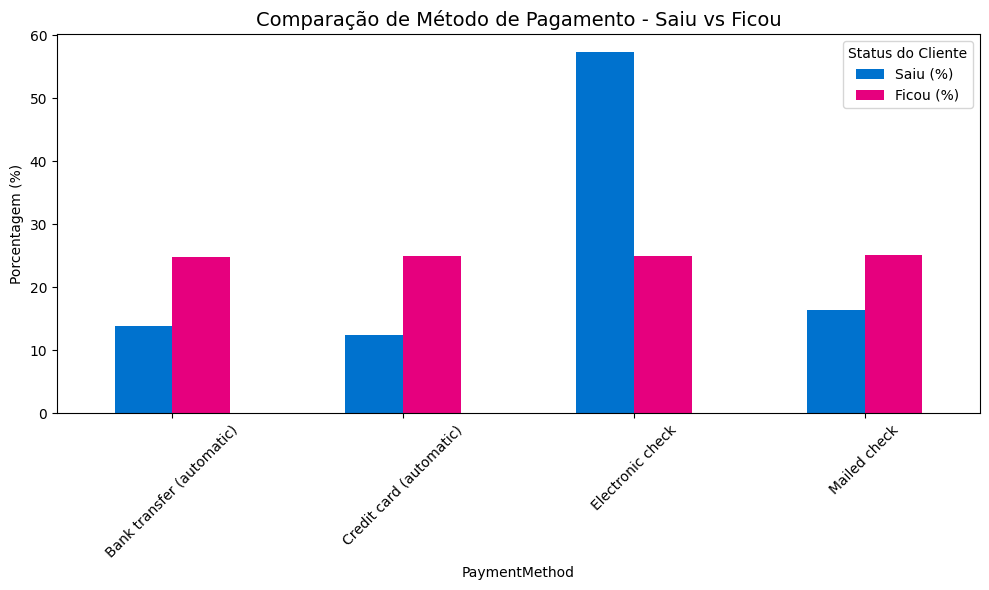

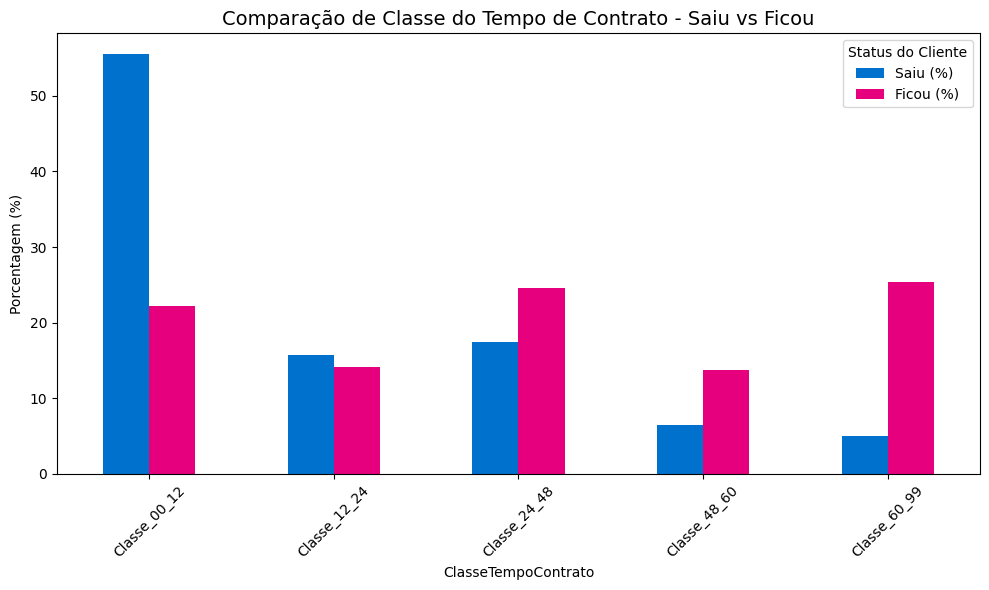

In [331]:
dados_churn = dados[dados['Churn'] == True]
dados_ficou = dados[dados['Churn'] == False]

compare_bar(dados_churn, dados_ficou, "PaymentMethod", "Método de Pagamento")
compare_bar(dados_churn, dados_ficou, "ClasseTempoContrato", "Classe do Tempo de Contrato")


### Análise das Variáveis Numéricas

In [332]:
def plot_histograms(data_churn, data_no_churn, variables, labels, size=(10, 4)):
    """
    Plota histogramas comparativos para variáveis numéricas entre grupos de churn.
    
    Parâmetros:
    - data_churn: DataFrame com clientes que saíram (Churn = True)
    - data_no_churn: DataFrame com clientes que ficaram (Churn = False)
    - variables: lista de colunas numéricas
    - labels: [label_churn, label_no_churn]
    - size: tamanho da figura (default (10, 4))
    """
    for var in variables:
        plt.figure(figsize=size)

        # Histograma: clientes que saíram
        plt.hist(
            data_churn[var], bins=15, alpha=0.8,
            color=a3data_colors[2], label=labels[0]
        )

        # Histograma: clientes que ficaram
        plt.hist(
            data_no_churn[var], bins=15, alpha=0.8,
            color=a3data_colors[1], label=labels[1]
        )

        # Título e eixos
        plt.title(f"Distribuição de {var} - {labels[0]} vs {labels[1]}", fontsize=14)
        plt.xlabel(var, fontsize=12)
        plt.ylabel("Frequência", fontsize=12)
        plt.legend(title="Status do Cliente", fontsize=10)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()


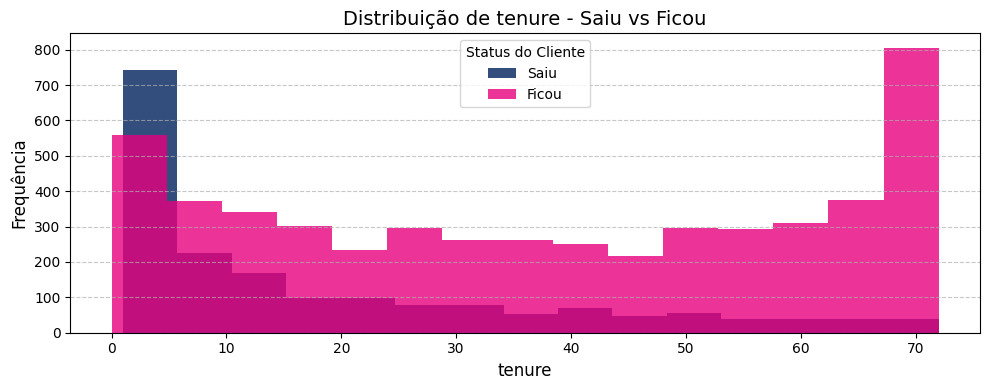

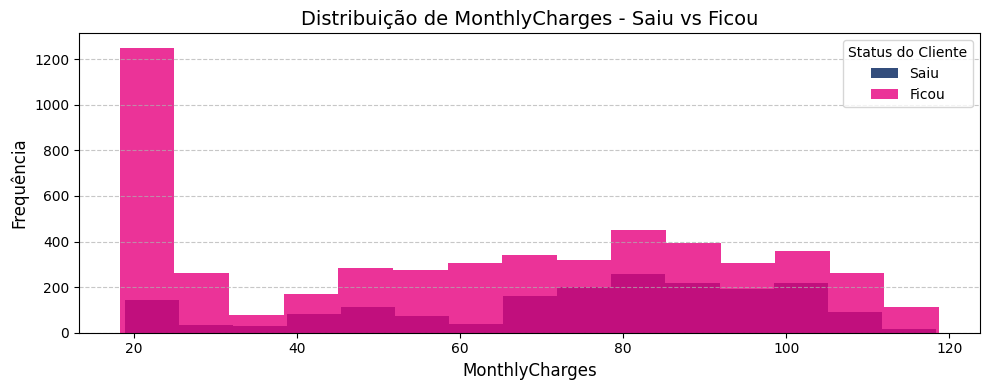

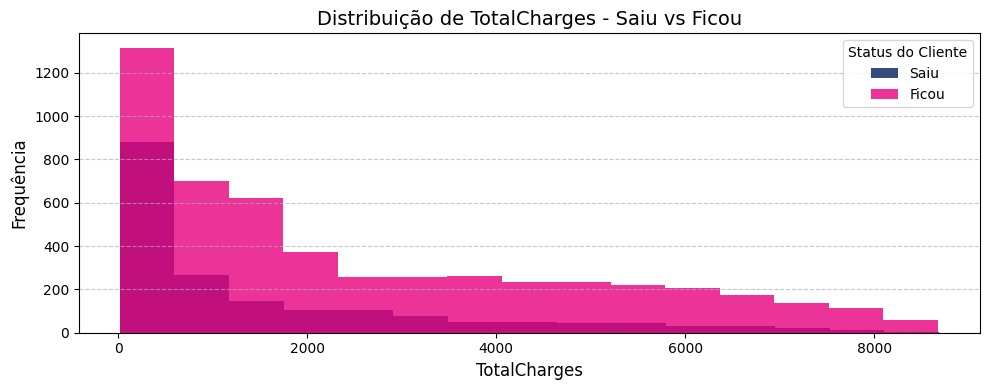

In [333]:
plot_histograms(
    dados[dados['Churn'] == True],   
    dados[dados['Churn'] == False],  
    num_vars,                        
    ['Saiu', 'Ficou']                
)


Muito importante a análise de tempo nde contrato dos clientes que churnaram e que ficaram, visto que parece ser um fator de extrema importancia no comportamento do cliente que sai. </br>
O custo MENSAL por cliente que fica é mais alto do que o custo de manutenção de cliente que sai, mas o custo TOTAL por cliente que sai também ganha destaque. mesmo assim o cliente que fica tambem apresenta um custo alto total.

In [334]:
dados.loc[dados.TotalCharges < 200].groupby('Churn').describe().T

Churn                      False       True 
SeniorCitizen  count  607.000000  574.000000
               mean     0.054366    0.196864
               std      0.226925    0.397976
               min      0.000000    0.000000
               25%      0.000000    0.000000
               50%      0.000000    0.000000
               75%      0.000000    0.000000
               max      1.000000    1.000000
tenure         count  607.000000  574.000000
               mean     3.121911    1.604530
               std      2.593142    1.208773
               min      1.000000    1.000000
               25%      1.000000    1.000000
               50%      2.000000    1.000000
               75%      4.000000    2.000000
               max     12.000000   11.000000
MonthlyCharges count  607.000000  574.000000
               mean    34.376853   56.895993
               std     20.320753   23.974852
               min     18.750000   18.850000
               25%     19.950000   36.037500
               50%     20.700000   59.925000
               75%     47.275000   75.700000
               max    100.200000  102.450000
TotalCharges   count  607.000000  574.000000
               mean    86.498105   82.841638
               std     55.240435   47.244967
               min     18.800000   18.850000
               25%     42.150000   48.687500
               50%     74.600000   74.450000
               75%    134.050000   99.750000
               max    199.850000  198.000000

### Analisando Correlações entre Variáveis Numéricas

In [335]:
variables = ['MonthlyCharges', 'TotalCharges', 'tenure']
target = 'Churn'

dados_corr = pd.concat([dados[variables], dados[target]], axis=1)

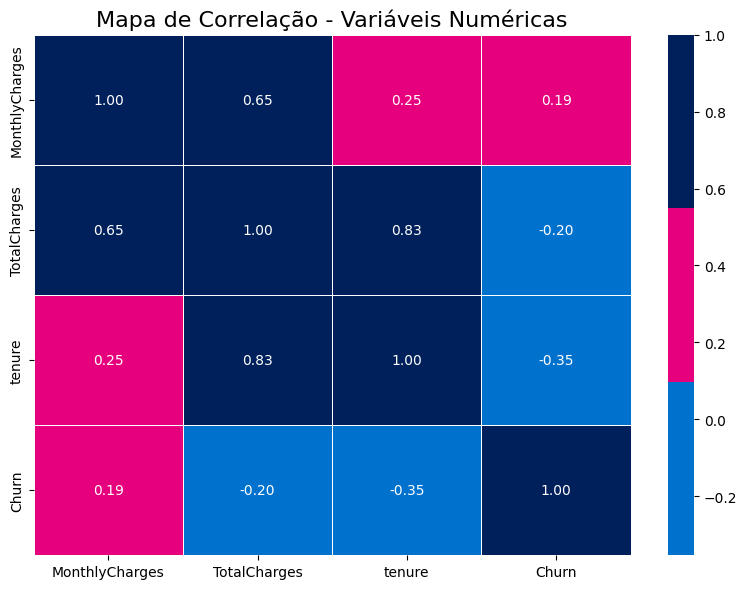

In [336]:
dados_corr = dados_corr.dropna()

correlation_matrix = dados_corr.corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(
    correlation_matrix, 
    annot=True,  
    fmt=".2f",   
    cmap=a3data_colors,  
    linewidths=0.5
)


plt.title("Mapa de Correlação - Variáveis Numéricas", fontsize=16)
plt.tight_layout()

# Exibir o gráfico
plt.show()

Como visto, a correlacao negativa entre o tempo de contrato e o churn é negativa, quanto maior um, menor o outro e a correlacao positiva entre custo total e mensal é alta, pois uma deriva da outra.</br>

### Análise das Faixas de Contrato
Como a variável de tempo de contrato parece influenciar bastante a decisão, parece interessante a entender melhor essa variavel e seu comportamento. 

In [337]:
dados.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ClasseTempoContrato
0,7569-NMZYQ,Female,0,True,True,72,True,Yes,Fiber,Yes,Yes,Yes,Yes,Yes,Yes,Biennial,True,Bank transfer (automatic),118.75,8672.45,False,Classe_60_99


In [338]:
freq_tab_01  =  dados[dados.Churn].groupby('ClasseTempoContrato').customerID.nunique().reset_index()
freq_tab_01.columns = ['tenure', 'clients']

freq_tab_01

,tenure,clients
0,Classe_00_12,1037
1,Classe_12_24,294
2,Classe_24_48,325
3,Classe_48_60,120
4,Classe_60_99,93


In [339]:
freq_tab_02  =  dados[~dados.Churn].groupby('ClasseTempoContrato').customerID.nunique().reset_index()
freq_tab_02.columns = ['tenure', 'clients']

freq_tab_02

,tenure,clients
0,Classe_00_12,1149
1,Classe_12_24,730
2,Classe_24_48,1269
3,Classe_48_60,712
4,Classe_60_99,1314


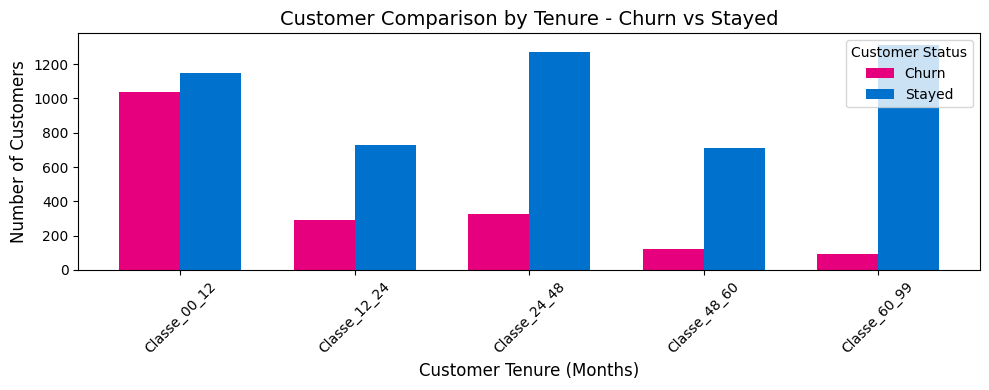

In [340]:
merged_data = pd.merge(
    freq_tab_01, freq_tab_02, on="tenure", how="outer", suffixes=("_Churn", "_NoChurn")
).fillna(0)

merged_data = merged_data.sort_values(by="tenure")

x_labels = merged_data["tenure"]
clientes_churn = merged_data["clients_Churn"]
clientes_no_churn = merged_data["clients_NoChurn"]

plt.figure(figsize=(10, 4))
bar_width = 0.35
x = range(len(x_labels))

plt.bar(x, clientes_churn, bar_width, label="Churn", color="#E6007E")  
plt.bar([i + bar_width for i in x], clientes_no_churn, bar_width, label="Stayed", color='#0072CE')

plt.xlabel("Customer Tenure (Months)", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.title("Customer Comparison by Tenure - Churn vs Stayed", fontsize=14)
plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=45)
plt.legend(title="Customer Status")
plt.tight_layout()

plt.show()


Grande parte do pessoal sai nos 12 primeiros meses. Cabe uma açao de marketing para tentar garantir que os clientes, no primeiro ano de relacionamento, tenha maior assistencia. 

In [341]:
dados.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'ClasseTempoContrato'],
      dtype='object')

In [342]:
freq_tab_01  =  dados[dados.Churn].groupby('ClasseTempoContrato').MonthlyCharges.mean().reset_index()
freq_tab_01.columns = ['tenure', 'Custo Médio Mensal']

freq_tab_02  =  dados[~dados.Churn].groupby('ClasseTempoContrato').MonthlyCharges.mean().reset_index()
freq_tab_02.columns = ['tenure', 'Custo Médio Mensal']

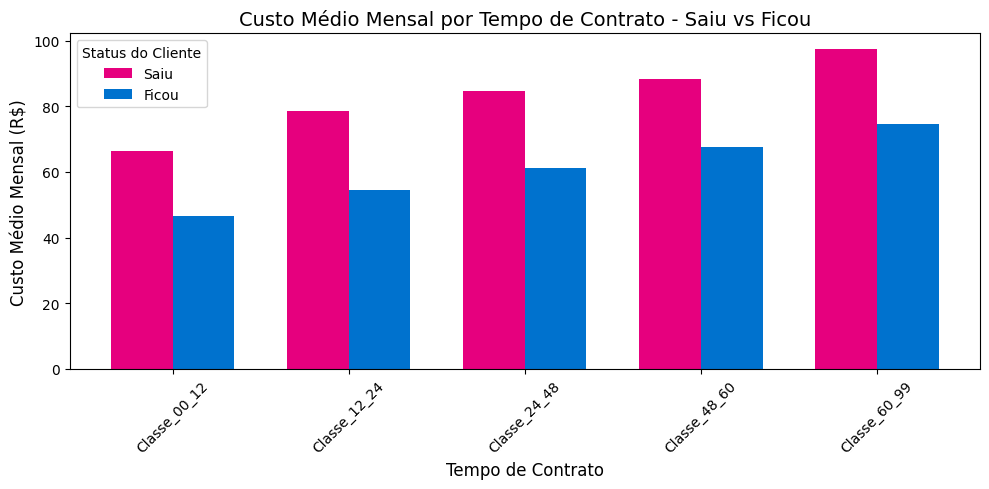

In [343]:
merged_data = pd.merge(
    freq_tab_01, freq_tab_02, on="tenure", how="outer", suffixes=("_Saiu", "_Ficou")
).fillna(0)  

merged_data = merged_data.sort_values(by="tenure") 
x_labels = merged_data["tenure"]
custo_saiu = merged_data["Custo Médio Mensal_Saiu"]
custo_ficou = merged_data["Custo Médio Mensal_Ficou"]


plt.figure(figsize=(10, 5))
bar_width = 0.35
x = range(len(x_labels))

plt.bar(x, custo_saiu, bar_width, label="Saiu", color="#E6007E")  
plt.bar([i + bar_width for i in x], custo_ficou, bar_width, label="Ficou", color='#0072CE')  # Cinza claro

plt.xlabel("Tempo de Contrato", fontsize=12)
plt.ylabel("Custo Médio Mensal (R$)", fontsize=12)
plt.title("Custo Médio Mensal por Tempo de Contrato - Saiu vs Ficou", fontsize=14)
plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=45)
plt.legend(title="Status do Cliente")
plt.tight_layout()

plt.show()

O custo medio mensal por cliente que saiu, independente da faixa de tempo de relacionamento com a empresa, é mais alto. O custo certamente influencia na desicao de churn do cliente.

In [344]:
freq_tab_01  =  dados[dados.Churn].groupby('ClasseTempoContrato').TotalCharges.mean().reset_index()
freq_tab_01.columns = ['tenure', 'Custo Médio Total']

freq_tab_02  =  dados[~dados.Churn].groupby('ClasseTempoContrato').TotalCharges.mean().reset_index()
freq_tab_02.columns = ['tenure', 'Custo Médio Total']

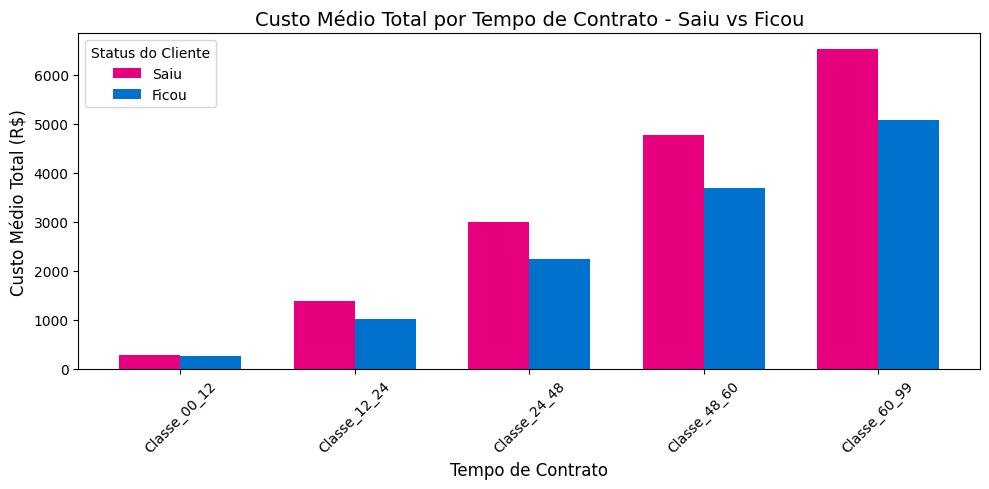

In [345]:
merged_data = pd.merge(
    freq_tab_01, freq_tab_02, on="tenure", how="outer", suffixes=("_Saiu", "_Ficou")
).fillna(0)  

merged_data = merged_data.sort_values(by="tenure")  # Ordenar por Tempo Contrato
x_labels = merged_data["tenure"]
custo_total_saiu = merged_data["Custo Médio Total_Saiu"]
custo_total_ficou = merged_data["Custo Médio Total_Ficou"]

plt.figure(figsize=(10, 5))
bar_width = 0.35
x = range(len(x_labels))

plt.bar(x, custo_total_saiu, bar_width, label="Saiu", color="#E6007E") 
plt.bar([i + bar_width for i in x], custo_total_ficou, bar_width, label="Ficou", color='#0072CE')  
plt.xlabel("Tempo de Contrato", fontsize=12)
plt.ylabel("Custo Médio Total (R$)", fontsize=12)
plt.title("Custo Médio Total por Tempo de Contrato - Saiu vs Ficou", fontsize=14)
plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=45)
plt.legend(title="Status do Cliente")
plt.tight_layout()

plt.show()

O custo medio total por tempo de relacionamento é mais alto para pessoas que sairam também, mas aumentando gradativamente por faixa de tempo de contrato. 

## Feature Engineering

Separando as colunas (variáveis) em seus respectivos tipos:
* ID
* Resposta
* Categórico: duas classes (binário)
* Categórico: múltiplas classes
* Numérico
Começamos pelas variáveis resposta e ID.

In [346]:
dados.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ClasseTempoContrato
0,7569-NMZYQ,Female,0,True,True,72,True,Yes,Fiber,Yes,Yes,Yes,Yes,Yes,Yes,Biennial,True,Bank transfer (automatic),118.75,8672.45,False,Classe_60_99


In [347]:
var_id = ['customerID']
var_resposta = ['Churn']

In [348]:
var_cat   = dados.nunique()[dados.nunique() < 10].keys().tolist()
var_cat   = [var for var in var_cat if var not in var_resposta + var_id]

In [349]:
var_num = [var for var in dados.columns if var not in var_cat + var_resposta + var_id]

In [350]:
var_bin   = dados.nunique()[dados.nunique() == 2].keys().tolist()
var_bin   = [var for var in var_bin if var not in var_id + var_resposta]

In [351]:
var_multi = [var for var in var_cat if var not in var_bin]

Transformando as variaveis.

#### Variáveis Binárias

In [352]:
encoders = list()

for var in var_bin:
    le = LabelEncoder()
    le_fitted = le.fit(dados[var])
    dados[var] = le_fitted.transform(dados[var])
    encoders.append((var, le_fitted))

Fazendo a mesma coisa com a variável resposta.

In [353]:
dados[var_resposta] = dados[var_resposta] * 1

In [354]:
dados.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ClasseTempoContrato
0,7569-NMZYQ,0,0,1,1,72,1,Yes,Fiber,Yes,Yes,Yes,Yes,Yes,Yes,Biennial,1,Bank transfer (automatic),118.75,8672.45,0,Classe_60_99
1,8984-HPEMB,0,0,0,0,71,1,Yes,Fiber,Yes,Yes,Yes,Yes,Yes,Yes,Biennial,1,Electronic check,118.65,8477.60,0,Classe_60_99
2,5989-AXPUC,0,0,1,0,68,1,Yes,Fiber,Yes,Yes,Yes,Yes,Yes,Yes,Biennial,0,Mailed check,118.60,7990.05,0,Classe_60_99


#### Variáveis Categóricas Multi-Classe

In [355]:
# funcoes de modelagem
def predicoes_binarias(df_input, cols_keep, cols_model, path_model='../Modelos/xgb_otimizado.pkl'):
    # Carrega o modelo treinado
    model = joblib.load(path_model)
    
    # Inicializa o df com as predições
    df = pd.DataFrame()
    for col in cols_keep:
        df[col] = df_input[col].values
    
    # norm
    input_model = normalizing(df_input, cols_model)
    
    prob_class = model.predict_proba(input_model)[:, 1]  # Probabilidade da classe positiva
    
    df['PROB_CLASSE_POSITIVA'] = prob_class
    df['CLASSE_PREDITA'] = (prob_class > 0.5).astype(int)  # Classifica como 1 se a probabilidade da classe positiva (que eu quero prever) for maior que 0.5, senão como 0
    # Adicione as colunas de cols_model ao DataFrame de predição
    for col in cols_model:
        df[col] = df_input[col].values
        
        
    return df

def get_cols(df, target='cancellation', cols2exc=[]):
    '''
    Separa as features para normalização, enconding e target
    '''
    # features que passarão pelo enconding - objetos 
    cols2enc = [target] + [x for x in df.select_dtypes(include=['object']).columns if x not in cols2exc and x not in [target]]
    # features que serão normalizadas
    cols2norm = [x for x in df.select_dtypes(include=['int64', 'float64']).columns if x not in cols2exc and x not in cols2enc] 
        
    return cols2enc, cols2norm 

def normalizing(df, target='cancellation', cols2exc=[]):
    '''
    Aplica o enconding e normalização aos dados
    '''   
    # separate cols
    cols2enc, cols2norm = get_cols(df, target, cols2exc)
    #print(cols2enc, cols2norm)
    df_norm = pd.DataFrame()
    
    # encoding 
    enc_mapping = list()
    encoder = LabelEncoder()
    for col in cols2enc:
        encoded = encoder.fit_transform(df[col])#.astype(str))
        df_norm[col] = encoded
        mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        enc_mapping.append([col, mapping])
        
    # normalizing
    scaler = MinMaxScaler()
    for col in cols2norm:
        encoded = scaler.fit_transform(df[col].astype(float).values.reshape(-1, 1))
        df_norm[col] = encoded
        
    return df_norm, enc_mapping

def get_model(X, y, nsplit=3, min_features=10, njobs=-1):
    '''
    Retorna o RFE + CV 
    '''
    rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
    kfold = StratifiedKFold(n_splits=nsplit, shuffle=True) 
    cv = kfold.split(X, y)
    return RFECV(estimator=rfc, step=nsplit, min_features_to_select=min_features, cv=cv, n_jobs=njobs)

def get_features_info(rfecv, X, df, style=None):
    '''
    Retorna a análise das features selecionadas pelo RFECV + dataframe com essas features
    '''
    print('Número ótimo de variáveis selecionadas pelo RFE: {}'.format(rfecv.n_features_))
    
    if not style:
        style = {'font-family': 'manrope', 
                 'color-header': 'white',
                 'background-header': '#000000',
                 'header-fsize': '16px',
                 'background-even': '#7a7423',
                 'background-odd': '#a7e82b',
                 'rows-fsize' : '14px',
                 'figsize': (12,12),
                 'cmap': 'Greens',
                 'color': '#c04cfd'}
        
    # Visualizando as importancia das variáveis selecionadas
    X2 = X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1)
    dset = pd.DataFrame()
    dset['attr'] = X2.columns
    dset['importance'] = rfecv.estimator_.feature_importances_
    dset = dset.sort_values(by='importance', ascending=True)

    fig, axs = plt.subplots(2,1, figsize=style['figsize'], gridspec_kw={'height_ratios': [1, 3]})
    fig.suptitle('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold')
    axs[0].plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], 
                color=style['color'], linewidth=3)
    axs[0].set_xlabel('Number of features selected', fontsize=14, labelpad=20)
    axs[0].set_ylabel('% Correct Classification', fontsize=14, labelpad=20)
    axs[1].barh(y=dset['attr'], width=dset['importance'], color=style['color'])
    axs[1].set_xlabel('Importancia', fontsize=14, labelpad=20)
    
    # Tabela com as variáveis e seu percentual de importancia
    df_import = pd.DataFrame(zip(dset.attr, [f'{x*100:.2f}%' for x in dset.importance.sort_values(ascending=True)]), columns=['Variável', 'Importancia'])
    print(df_import)

    # Variáveis selecionadas pelo RFE/RF
    cols_rfe = dset.attr
    # Dataframe com as features selecionadas 
    return df_import, df[cols_rfe.tolist()]

def work_model(model=None, ftype='pkl', path2save='../../models/', outname='model'):

    '''
    Salva ou carrega um modelo

    inputs:
    model = modelo a ser salvo
    ftype = tipo do arquivo, pkl ou joblib
    path2save = path para salvar/carregar o modelo: ex.: '../../models'
    outname = nome para o output - nome do modelo 

    output:
    retorna = arquivo salvo ou modelo carregado

    '''

    import os
    import joblib
    import pickle

    outname = os.path.join(path2save, outname)
    outfile = f"{outname}.{ftype}"

    if ftype == 'pkl':
        if model: # save
            pickle.dump(model, open(outfile, 'wb'))
            print(f'Model saved as {outfile}')  

        else: # load
            return pickle.load(open(f'{outfile}', 'rb'))

    else:
        if model:
            joblib.dump(model, outfile)
            print(f'Model saved as {outfile}')  

        else:
            return joblib.load(f'{outfile}')

def fit_model(X, y, model=LogisticRegression()):
    '''
    Fit modelos aos dados
    '''
    model.fit(X, y)
    return model

def model_metrics(X_test, y_test, model,  average_type='macro'):
    y = y_test
    y_pred = xgb.predict(X_test)

    model_metrics_dict = {'Acurácia': accuracy_score(y, y_pred),
                          'Precisão': precision_score(y, y_pred, average=average_type),
                          'Recall': recall_score(y, y_pred, average=average_type),
                              'F1-Score': f1_score(y, y_pred, average=average_type)}


    return model_metrics_dict

In [356]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customerID           7043 non-null   object 
 1   gender               7043 non-null   int64  
 2   SeniorCitizen        7043 non-null   int64  
 3   Partner              7043 non-null   int64  
 4   Dependents           7043 non-null   int64  
 5   tenure               7043 non-null   int64  
 6   PhoneService         7043 non-null   int64  
 7   MultipleLines        7043 non-null   object 
 8   InternetService      7043 non-null   object 
 9   OnlineSecurity       7043 non-null   object 
 10  OnlineBackup         7043 non-null   object 
 11  DeviceProtection     7043 non-null   object 
 12  TechSupport          7043 non-null   object 
 13  StreamingTV          7043 non-null   object 
 14  StreamingMovies      7043 non-null   object 
 15  Contract             7043 non-null   o

In [357]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod', 'ClasseTempoContrato'
]

numeric_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
    'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges'
]

# Target
target = 'Churn'

In [358]:
#colun as do tipo 'object'
cat_cols = dados.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col != 'customerID']

#### Variáveis Numéricas

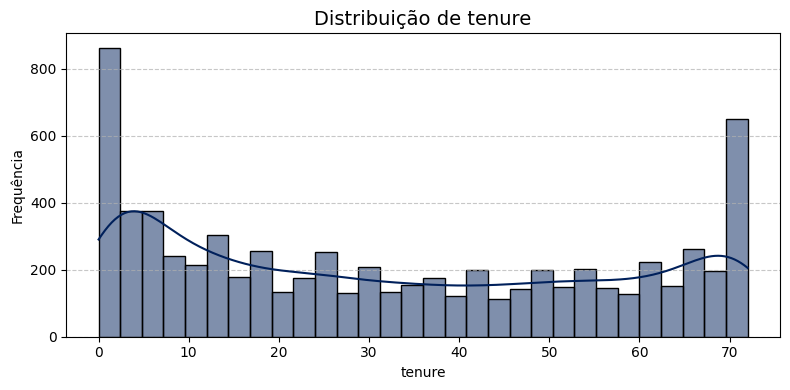

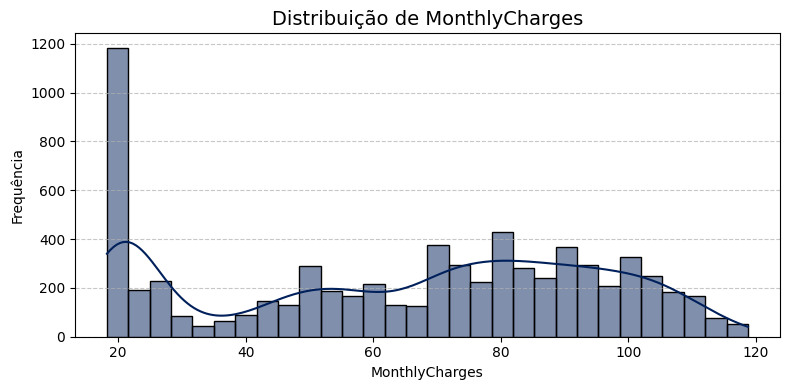

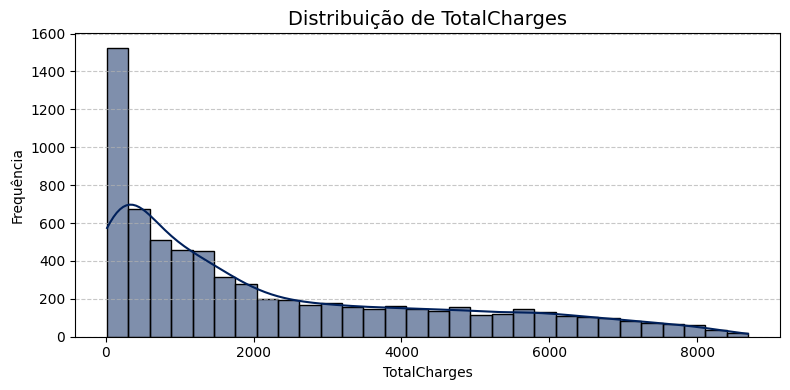

In [359]:
def plot_distribuicoes(df, cols, title_prefix="Distribuição de"):
    """
    Plota histogramas com KDE para variáveis numéricas.
    """
    for col in cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True, bins=30, color="#00205B")
        plt.title(f"{title_prefix} {col}", fontsize=14)
        plt.xlabel(col)
        plt.ylabel("Frequência")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Visualizar antes da normalização
plot_distribuicoes(dados, var_num)

In [360]:
# Passando o scaler para normalizar a distribuição dos dados.
std = MinMaxScaler()

scaled = std.fit_transform(dados[var_num])
scaled = pd.DataFrame(scaled, columns = var_num)

In [361]:
dados.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ClasseTempoContrato
6043,5857-XRECV,0,0,0,1,2,1,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Annual,0,Bank transfer (automatic),20.50,38.25,0,Classe_00_12
2767,4631-OACRM,1,1,0,0,15,1,No,Fiber,No,No,No,No,No,Yes,Monthly,1,Electronic check,79.40,1156.10,1,Classe_12_24
4864,7742-MYPGI,0,0,1,1,6,1,No,DSL,No,No,No,Yes,No,No,Monthly,1,Mailed check,48.80,297.35,0,Classe_00_12
4372,1750-CSKKM,1,0,0,1,9,1,No,DSL,No,No,No,No,Yes,No,Monthly,0,Electronic check,55.35,449.75,1,Classe_00_12
3333,6513-EECDB,1,1,1,0,1,1,Yes,Fiber,No,No,No,No,No,No,Monthly,1,Electronic check,73.55,73.55,1,Classe_00_12
5312,3472-OAOOR,1,0,1,1,19,0,No phone service,DSL,Yes,Yes,No,No,No,No,Monthly,1,Mailed check,34.95,610.20,0,Classe_12_24
6457,4895-TMWIR,1,1,1,0,11,1,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Monthly,0,Mailed check,19.95,214.75,1,Classe_00_12
2168,3834-XUIFC,1,0,0,0,7,1,Yes,Fiber,No,No,No,No,No,Yes,Monthly,1,Mailed check,85.20,602.55,1,Classe_00_12
1838,0829-XXPLX,0,0,0,0,20,1,No,Fiber,Yes,No,Yes,No,Yes,No,Monthly,1,Bank transfer (automatic),89.40,1871.15,0,Classe_12_24
412,1452-UZOSF,1,0,1,1,72,1,Yes,Fiber,Yes,Yes,Yes,Yes,Yes,No,Biennial,1,Credit card (automatic),106.10,7548.60,0,Classe_60_99


In [362]:
from sklearn.preprocessing import OneHotEncoder

# Lista de colunas categóricas para aplicar o OneHotEncoder
cat_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod', 'ClasseTempoContrato'
]

# Aplicar OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False)
ohe_transformed = ohe.fit_transform(dados[cat_cols])
ohe_columns = ohe.get_feature_names_out(cat_cols)

# Criar DataFrame com os dados codificados
df_ohe = pd.DataFrame(ohe_transformed, columns=ohe_columns, index=dados.index)

# Concatenar com os dados originais, excluindo as colunas originais categóricas
dados = pd.concat([dados.drop(columns=cat_cols), df_ohe], axis=1)
dados.head(10)
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   gender                                 7043 non-null   int64  
 2   SeniorCitizen                          7043 non-null   int64  
 3   Partner                                7043 non-null   int64  
 4   Dependents                             7043 non-null   int64  
 5   tenure                                 7043 non-null   int64  
 6   PhoneService                           7043 non-null   int64  
 7   PaperlessBilling                       7043 non-null   int64  
 8   MonthlyCharges                         7043 non-null   float64
 9   TotalCharges                           7032 non-null   float64
 10  Churn                                  7043 non-null   int64  
 11  Mult

In [363]:
dados.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber,InternetService_No internet service,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Biennial,Contract_Monthly,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,ClasseTempoContrato_Classe_12_24,ClasseTempoContrato_Classe_24_48,ClasseTempoContrato_Classe_48_60,ClasseTempoContrato_Classe_60_99
0,7569-NMZYQ,0,0,1,1,72,1,1,118.75,8672.45,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [364]:
# Inserindo variáveis NOISE e separando features do target (tecnica RANDOM BAR)

cols2exc=["customerID"]
target = ['Churn']

# Insere noise
dados['NOISE1'] = np.random.normal(0, 1, dados.shape[0])
dados['NOISE2'] = np.random.rand(dados.shape[0])

X = dados.drop(cols2exc+target, axis=1) 
y = dados[target[0]].values 

CPU times: user 6.39 s, sys: 11.9 ms, total: 6.4 s
Wall time: 12.8 s
Número ótimo de variáveis selecionadas: 15
Número ótimo de variáveis selecionadas pelo RFE: 15
                               Variável Importancia
0                       TechSupport_Yes       1.60%
1                               Partner       1.63%
2                                gender       1.80%
3                    OnlineSecurity_Yes       1.90%
4                      PaperlessBilling       2.01%
5   StreamingMovies_No internet service       2.03%
6        PaymentMethod_Electronic check       3.60%
7                 InternetService_Fiber       4.49%
8                     Contract_Biennial       4.53%
9                      Contract_Monthly       8.96%
10                               NOISE1      11.82%
11                               NOISE2      11.94%
12                               tenure      14.25%
13                         TotalCharges      14.70%
14                       MonthlyCharges      14.74%


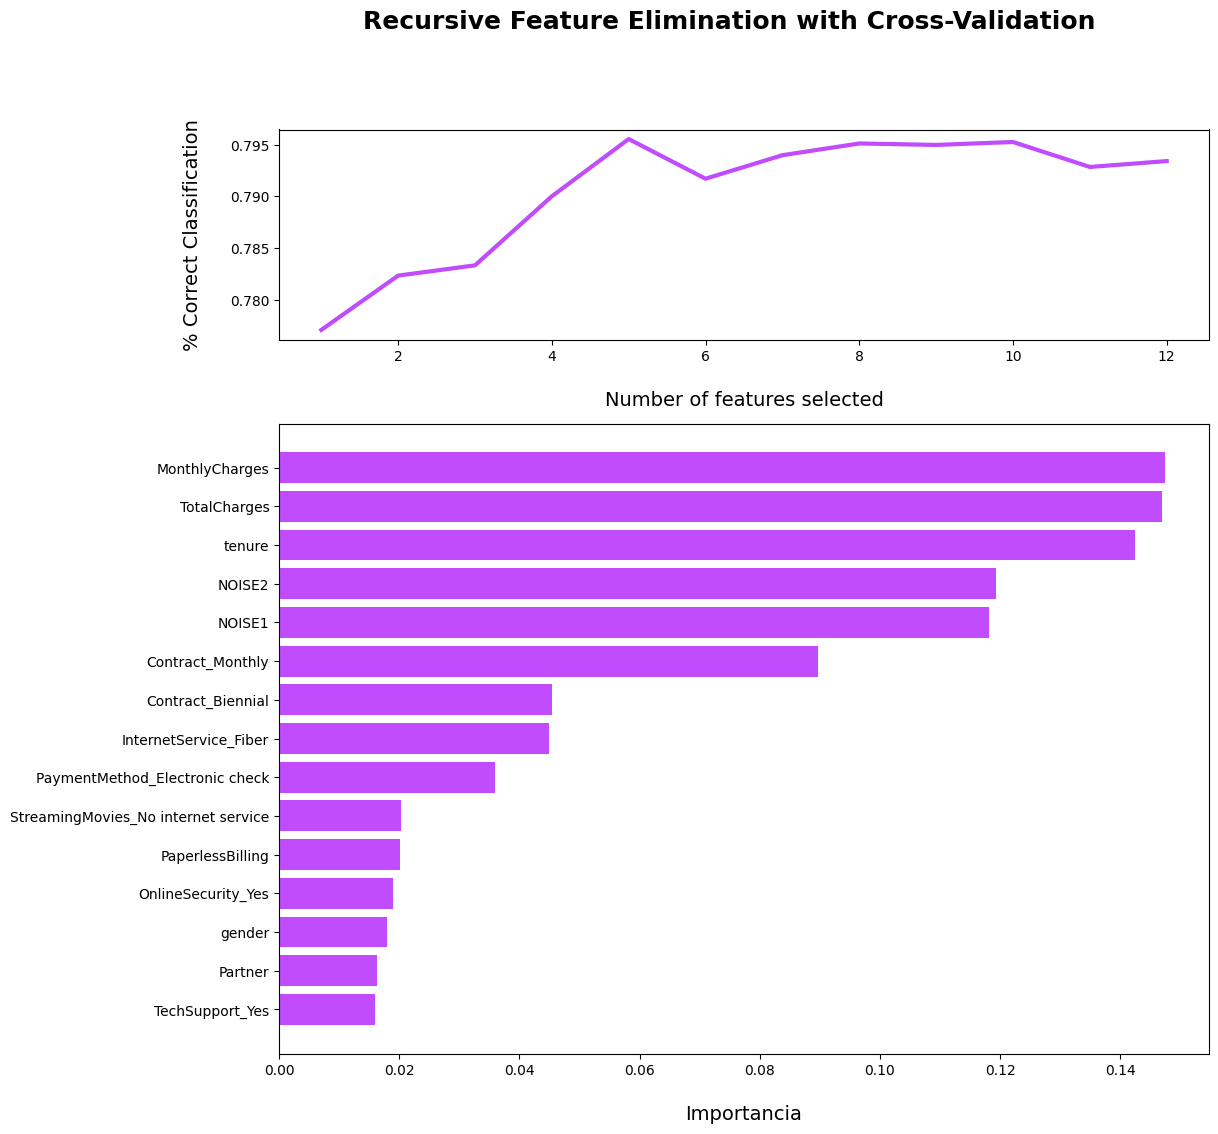

In [365]:
# Instanciando e ajustar o modelo
rfecv = get_model(X, y, nsplit=3, min_features=5)
%time rfecv.fit(X, y)

print(f"Número ótimo de variáveis selecionadas: {rfecv.n_features_}")

importancia_features, df_selecionado = get_features_info(rfecv, X, dados)

In [366]:
# Catboost classifier - traina  um modelo de classificação utilizando o 
# CatBoost e seleciona as features mais relevantes para o problema com
#  base nos valores SHAP (SHapley Additive exPlanations) 
from catboost import CatBoostClassifier, Pool
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    random_state=42,
    early_stopping_rounds=100,
    posterior_sampling=True,
    loss_function="Logloss",
    eval_metric="AUC",
    metric_period=100,
)

# Selecionando as melhores features
selected_features = model.select_features(
    X=X,
    y=y,
    features_for_select=X.columns,
    num_features_to_select=15, 
    algorithm="RecursiveByShapValues",
    steps=5,
    train_final_model=False,
    verbose=False,
)

Step #1 out of 5
Feature #21 eliminated
Feature #23 eliminated
Feature #19 eliminated
Feature #15 eliminated
Feature #13 eliminated
Feature #9 eliminated
Step #2 out of 5
Feature #33 eliminated
Feature #17 eliminated
Feature #32 eliminated
Feature #31 eliminated
Feature #30 eliminated
Step #3 out of 5
Feature #12 eliminated
Feature #18 eliminated
Feature #27 eliminated
Feature #3 eliminated
Step #4 out of 5
Feature #22 eliminated
Feature #2 eliminated
Feature #29 eliminated
Step #5 out of 5
Feature #24 eliminated
Feature #25 eliminated
Feature #16 eliminated


In [367]:
index = list(selected_features.get('selected_features'))
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    random_state=42,
    early_stopping_rounds=100,
    posterior_sampling=True,
    loss_function="Logloss",
    eval_metric="AUC",
    metric_period=100,
)

index_att = list(np.sort((index)))
index_att

[0, 1, 4, 5, 6, 7, 8, 10, 11, 14, 20, 26, 28, 34, 35]

In [368]:
# fitando o modelo com as variaveis selecionadas pelo CBC
model.fit(X.iloc[:, index_att],y, verbose = False)

In [369]:
feature_importance = model.get_feature_importance(data=Pool(X.iloc[:, index_att], label=y), type="LossFunctionChange")
feature_importance = feature_importance.reshape(-1,1)
feature_importance = feature_importance[feature_importance > 0]* 100 
feature_importance

array([0.51583912, 0.39147074, 5.8766871 , 0.51032986, 0.48166351,
       5.48276241, 3.10618667, 0.29716934, 0.98935951, 0.38521582,
       0.42751976, 1.71810992, 0.84104788, 3.51032666, 3.24915279])

In [370]:
feature_importance_df = pd.DataFrame({
    'Feature': X.iloc[:,index_att].columns,
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != 'NOISE1']
feature_importance_df

,Feature,Importance
7,MultipleLines_Yes,0.297169
9,OnlineSecurity_Yes,0.385216
1,SeniorCitizen,0.391471
10,TechSupport_Yes,0.427520
4,PaperlessBilling,0.481664
3,PhoneService,0.510330
0,gender,0.515839
12,PaymentMethod_Electronic check,0.841048
8,InternetService_Fiber,0.989360
11,Contract_Monthly,1.718110


In [371]:
feature_clean = feature_importance_df['Feature']
feature_clean_list = feature_clean.tolist()

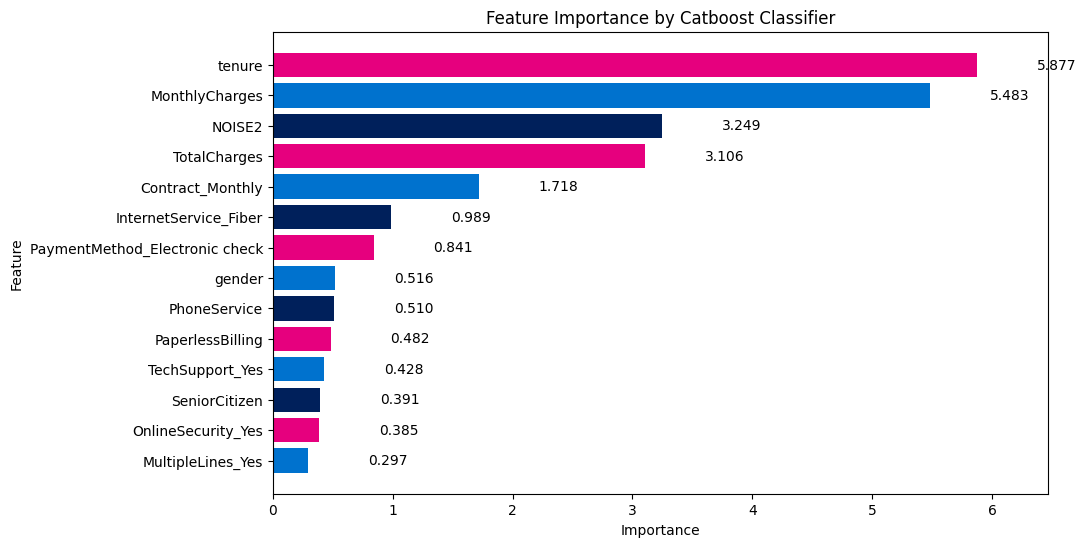

In [372]:
# Plotando o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=a3data_colors)

for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Catboost Classifier')
plt.xlim(0, max(feature_importance_df['Importance']) * 1.1)  # Definindo limites do eixo x

plt.show()

In [373]:
# Função que Salva ou carrega um modelo (ftype = tipo do arquivo, pkl ou joblib)
def work_model(model=None, ftype='pkl', path2save='../../models/', outname='model'):
    '''
    Salva ou carrega um modelo

    inputs:
    model = modelo a ser salvo
    ftype = tipo do arquivo, pkl ou joblib
    path2save = path para salvar/carregar o modelo: ex.: '../../models' 
    outname = nome para o output - nome do modelo

    output:
    retorna = arquivo salvo ou modelo carregado
    '''
    import os
    import joblib
    import pickle
    
    outname = os.path.join(path2save, outname) 
    outfile = f"{outname}.{ftype}" 
    if ftype == 'pkl':
        if model: # save
            pickle.dump(model, open(outfile, 'wb'))
            print(f'Model saved as {outfile}')   
        else: # load
            return pickle.load(open(f'{outfile}', 'rb'))
    else:
        if model:
            joblib.dump(model, outfile)
            print(f'Model saved as {outfile}')   
        else:
            return joblib.load(f'{outfile}')
        
# Parametros
def grid_search(X, y, model=LogisticRegression(), nsplit=3, param_grid={}, average_type='macro', njobs=-1):
    '''
    Executa o grid search
    '''
    kfold = StratifiedKFold(n_splits=nsplit, shuffle=True) 
    cv = kfold.split(X, y) 
    score = make_scorer(f1_score, average=average_type, greater_is_better=True)
    clf = GridSearchCV(model, param_grid, scoring=score, cv=cv, n_jobs=njobs)
    clf.fit(X, y)
    print('F1 score: ', clf.best_score_)
    print('Best parameters: ', clf.best_params_)
    return clf.cv_results_['mean_test_score']

def fit_model(X, y, model=LogisticRegression()):
    '''
    Fit modelos aos dados
    '''
    model.fit(X, y)
    return model

def eval_model(model, X, y, average_type='macro', labels=None, target_names=None):
    '''
    Retorna as metricas básicas de acordo com a predição
    '''
    y_pred = model.predict(X)
    #auc_scores = roc_auc_score(y, model.predict_proba(X))  #multi_class='ovr', average=None)
    class_order = [int(model.classes_[i]) for i in labels]
    #score_order = [auc_scores[n] for n in class_order]
    #aucs = [f'class {x}: {val:.2%}' for x, val in zip(target_names,score_order)]
    print('Report: \n', classification_report(y, y_pred, labels=labels, target_names=target_names))
    print('Accuracy: %.3f' % (accuracy_score(y, y_pred)))
    print('Precision: %.3f' % (precision_score(y, y_pred, average=average_type)))
    print('Recall: %.3f' % (recall_score(y, y_pred, average=average_type)))
    print('F1 score: %.3f' % (f1_score(y, y_pred, average=average_type)))
    #print('AUC scores for each class using One-vs-rest: \n', aucs)

def plot_conf_matrix(model, X_train, X_test, y_test, y_train,
                     eval_mode='ovr',
                     average_type='macro',
                     cmap_='Greens',
                     labels_order=None,
                     target_names=None,
                     tick_marks=None):
    
    y_pred_trainp = model.predict_proba(X_train)
    y_predp = model.predict_proba(X_test)
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    roc_test = roc_auc_score(y_test, y_pred)
    print(f'ROC_AUC score test: {roc_test*100:.2f}%')

    
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels_order)
    print('Confusion matrix for test: \n')
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    annot_ = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    annot_ = np.asarray(annot_).reshape(conf_matrix.shape)   
    sns.heatmap(conf_matrix, annot=annot_, fmt='', xticklabels=target_names, yticklabels=target_names, cmap=cmap_)

def eval_model_all(model, X, y, X_train, X_test, y_train, y_test, eval_mode='ovr', average_type='macro', cmap_='Greens', labels_order=None, target_names=None, tick_marks=None):
    '''
    Retorna todas as principais metricas levando em consideração dos os dados
    '''

    y_pred_trainp = model.predict_proba(X_train)
    y_predp = model.predict_proba(X_test) 
    y_allp = model.predict_proba(X)

    roc_train = roc_auc_score(y_train, y_pred_trainp) # multi_class=eval_mode)  
    roc_test = roc_auc_score(y_test, y_predp)# multi_class=eval_mode)
    roc_all = roc_auc_score(y, y_allp) #multi_class=eval_mode)
    print(f'ROC_AUC score train: {roc_train*100:.2f}%')
    print(f'ROC_AUC score test: {roc_test*100:.2f}%')
    print(f'ROC_AUC score all: {roc_all*100:.2f}% \n')
    
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    y_pall = model.predict(X)
    
    print(f'Accuracy for train: {accuracy_score(y_train, y_pred_train)*100:.2f}%')
    print(f'Accuracy for test: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print(f'Accuracy for all: {accuracy_score(y,y_pall)*100:.2f}% \n')
    
    sen_train = sensitivity_score(y_train, y_pred_train, average=average_type)
    sen_test = sensitivity_score(y_test, y_pred, average=average_type)
    sen_all = sensitivity_score(y, y_pall, average=average_type)
    spe_train = specificity_score(y_train, y_pred_train, average=average_type)
    spe_test = specificity_score(y_test, y_pred, average=average_type)
    spe_all = specificity_score(y, y_pall, average=average_type)
    print(f'Sensitivity for train: {sen_train*100:.2f}%, Specificity for train: {spe_train*100:.2f}')
    print(f'Sensitivity for test: {sen_test*100:.2f}%, Specificity for test: {spe_test*100:.2f}')
    print(f'Sensitivity for all: {sen_all*100:.2f}%, Specificity for all: {spe_all*100:.2f} \n')
                
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels_order)
    print('Confusion matrix for test: \n')
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    annot_ = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    annot_ = np.asarray(annot_).reshape(conf_matrix.shape)   
    sns.heatmap(conf_matrix, annot=annot_, fmt='', xticklabels=target_names, yticklabels=target_names, cmap=cmap_)

# Construindo um Modelo

In [375]:
feature_importance_df = feature_importance_df[-2:]
variaveis_selecionadas = list(feature_importance_df.Feature) 
variaveis_selecionadas

['MonthlyCharges', 'tenure']

In [240]:
# ajustando o df do modelo
df_rfe = dados[variaveis_selecionadas]
df_rfe['Churn'] = dados['Churn']
df_rfe

,MonthlyCharges,tenure,Churn
0,118.75,72,0
1,118.65,71,0
2,118.60,68,0
3,118.60,61,0
4,118.35,67,1
...,...,...,...
7038,18.70,53,0
7039,18.70,25,0
7040,18.55,36,0
7041,18.40,59,0


In [241]:
#separando a base de validação 
import shap
df_validation = shap.sample(df_rfe, nsamples= int(df_rfe.shape[0]* 0.10))
X_val = df_validation.drop('Churn', axis = 1)
y_val = df_validation['Churn']

#retirando os dados da validação da base principal

df_rfe = df_rfe.drop(df_validation.index)
df_rfe

,MonthlyCharges,tenure,Churn
0,118.75,72,0
1,118.65,71,0
2,118.60,68,0
3,118.60,61,0
4,118.35,67,1
...,...,...,...
7036,18.80,1,0
7037,18.75,2,0
7038,18.70,53,0
7040,18.55,36,0


<Axes: title={'center': 'Test sample'}, ylabel='count'>

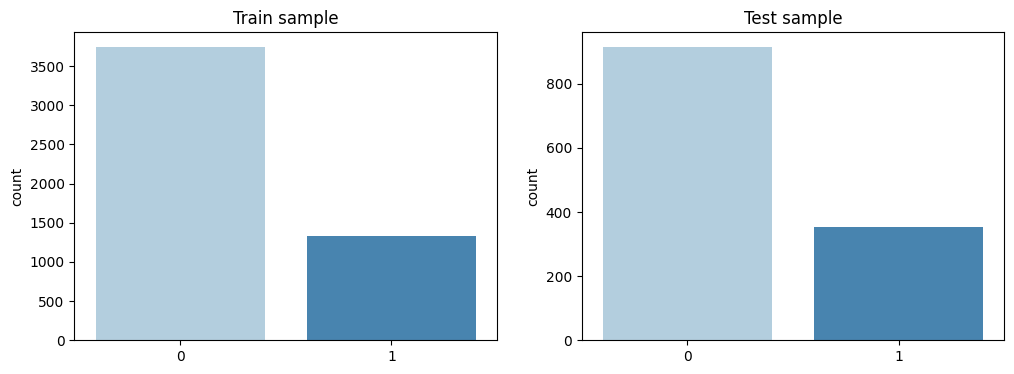

In [242]:
# Separa as features
cols2exc = []
target = ['Churn']

X = df_rfe.drop(cols2exc + target, axis=1) # features
y = df_rfe[target[0]].values # target

# Divide os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# check da distribuição dos targets
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].title.set_text("Train sample")
sns.countplot(x=y_train, ax=axs[0], palette='Blues')
axs[1].title.set_text("Test sample")
sns.countplot(x=y_test, ax=axs[1], palette='Blues')

In [243]:
class_validation = pd.DataFrame(pd.DataFrame(y_train).value_counts(normalize = True).mul(100).round(2))
class_validation #proporcao das classes 

,proportion
0,
0,73.81
1,26.19


In [244]:
# otimizando com Optuna
def objective(trial):
    param_dist = {
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 50),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    }

    clf = XGBClassifier(random_state=42, n_jobs=-1, **param_dist)

    score = cross_val_score(clf, X_train, y_train, cv=3, n_jobs=-1).mean()

    return -score  

study = optuna.create_study(direction='maximize')  # 'maximize' para maximizar o score
# OTIMIZANDO parametro
study.optimize(objective, n_trials=50)  

best_params = study.best_params

print("Melhores hiperparâmetros:", best_params)

[I 2025-11-10 21:46:27,635] A new study created in memory with name: no-name-fcf5b1ea-2f39-42a0-8ff2-c4436f4658af
/home/wsl/churn_furukawa/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:46:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight", "criterion", "max_features", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/home/wsl/churn_furukawa/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:46:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight", "criterion", "max_features", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/home/wsl/churn_furukawa/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:46:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight", "criterion", "max_features", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-11-10 21:46:28,538] Trial 0 finished with value

Melhores hiperparâmetros: {'max_features': 'log2', 'max_depth': 43, 'min_samples_split': 50, 'class_weight': 'balanced_subsample', 'criterion': 'log_loss'}


In [245]:
rfc_params = study.best_params
rfc_params['n_jobs'] = -1
rfc_params['random_state'] = 13 

rfc = fit_model(X_train, y_train, model=XGBClassifier(**rfc_params))

y_pred = rfc.predict(X_test)

eval_model(rfc, X_test, y_test, labels=[0,1], target_names=['No Churn','Churn'])

Report: 
               precision    recall  f1-score   support

    No Churn       0.81      0.84      0.82       915
       Churn       0.54      0.50      0.52       353

    accuracy                           0.74      1268
   macro avg       0.68      0.67      0.67      1268
weighted avg       0.74      0.74      0.74      1268

Accuracy: 0.742
Precision: 0.676
Recall: 0.667
F1 score: 0.671


In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def test_model(model, X_train, X_test, y_train, y_test, model_name):

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(f"\nMétricas para {model_name}:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))

algorithms = {
    "Random Forest": RandomForestClassifier(**best_params, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(**best_params, random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)
}

for model_name, model in algorithms.items():
    test_model(model, X_train, X_test, y_train, y_test, model_name)


Métricas para Random Forest:
              precision    recall  f1-score   support

    No Churn       0.86      0.75      0.80       933
       Churn       0.49      0.67      0.57       335

    accuracy                           0.73      1268
   macro avg       0.68      0.71      0.68      1268
weighted avg       0.76      0.73      0.74      1268

Matriz de Confusão:
[[700 233]
 [111 224]]

Métricas para XGBoost:
              precision    recall  f1-score   support

    No Churn       0.81      0.84      0.82       933
       Churn       0.49      0.44      0.46       335

    accuracy                           0.73      1268
   macro avg       0.65      0.64      0.64      1268
weighted avg       0.72      0.73      0.73      1268

Matriz de Confusão:
[[782 151]
 [189 146]]

Métricas para Logistic Regression:
              precision    recall  f1-score   support

    No Churn       0.81      0.91      0.86       933
       Churn       0.63      0.41      0.50       335

    ac

Balanceando as classes diretamente no modelo

In [247]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Exibe métricas de avaliação
print("Métricas do Modelo Random Forest com class_weight='balanced':")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

Métricas do Modelo Random Forest com class_weight='balanced':
              precision    recall  f1-score   support

    No Churn       0.80      0.85      0.83       933
       Churn       0.49      0.40      0.44       335

    accuracy                           0.73      1268
   macro avg       0.65      0.63      0.63      1268
weighted avg       0.72      0.73      0.72      1268

Matriz de Confusão:
[[797 136]
 [202 133]]


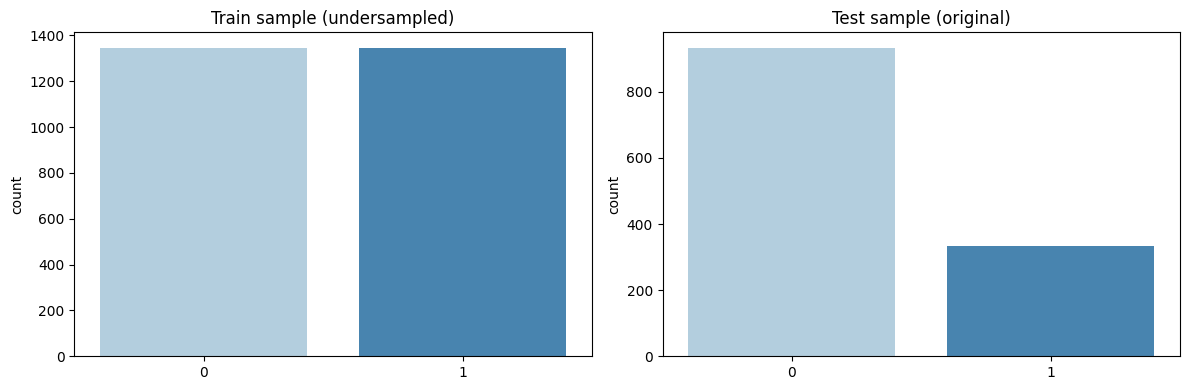


==== Random Forest ====
              precision    recall  f1-score   support

    No Churn       0.85      0.69      0.76       933
       Churn       0.43      0.65      0.52       335

    accuracy                           0.68      1268
   macro avg       0.64      0.67      0.64      1268
weighted avg       0.74      0.68      0.70      1268

Matriz de Confusão:
[[643 290]
 [117 218]]

==== XGBoost ====
              precision    recall  f1-score   support

    No Churn       0.87      0.68      0.76       933
       Churn       0.45      0.71      0.55       335

    accuracy                           0.69      1268
   macro avg       0.66      0.70      0.66      1268
weighted avg       0.76      0.69      0.71      1268

Matriz de Confusão:
[[637 296]
 [ 96 239]]

==== CatBoost ====
              precision    recall  f1-score   support

    No Churn       0.89      0.69      0.78       933
       Churn       0.47      0.77      0.59       335

    accuracy                    

In [251]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

#Undersampling na base de treino
rus = RandomUnderSampler(random_state=0)
X_train_bl, y_train_bl = rus.fit_resample(X_train, y_train)

# vizzz
fig, axs = plt.subplots(1, 2, figsize=[12, 4])
axs[0].set_title("Train sample (undersampled)")
sns.countplot(x=y_train_bl, ax=axs[0], palette='Blues')
axs[1].set_title("Test sample (original)")
sns.countplot(x=y_test, ax=axs[1], palette='Blues')
plt.tight_layout()
plt.show()

# teste de modelos
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

# treino e avaliacao de modelo
for nome, modelo in modelos.items():
    print(f'\n==== {nome} ====')
    modelo.fit(X_train_bl, y_train_bl)
    y_pred = modelo.predict(X_test)

    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))



Random Forest
No Churn (Classe 0):
Precisão: 0.85: Alta precisão, o modelo acerta bem quando prevê que o cliente não vai churnar.
Recall: 0.69 : 69% dos clientes que realmente ficaram foram corretamente identificados.
F1-Score: 0.76 : Boa harmonia entre precisão e recall, mostrando consistência para a classe majoritária.

Churn (Classe 1):
Precisão: 0.43 : Quando o modelo prevê "Churn", está certo em 43% dos casos.
Recall: 0.65 : Consegue identificar 65% dos clientes que realmente churnaram.
F1-Score: 0.52 : Moderada, com tendência a confundir churners e não churners.

Em geral - Acurácia: 68% : Classifica corretamente cerca de dois terços dos clientes. Média Macro: Recall (0.67) indica desempenho mais equilibrado entre as classes. 
Média Ponderada: Mostra que o modelo performa melhor na classe “No Churn”.

Erros Comuns:
290 falsos positivos: clientes previstos como churn, mas que não saíram.
117 falsos negativos: clientes que churnaram, mas o modelo não identificou.
Nesse caso os falsos positivos são caros para os clientes visto que afeta diretamente a retenção.

XGBoost

No Churn (Classe 0):
Precisão: 0.87 : Excelente precisão, poucas previsões erradas para essa classe.
Recall: 0.68 : Detecta 68% dos clientes que realmente permaneceram.
F1-Score: 0.76 : Sólido e estável, semelhante ao Random Forest.

Churn (Classe 1):
Precisão: 0.45 : Moderada, indicando algumas previsões incorretas.
Recall: 0.71 : Superior ao Random Forest, melhor identificação de churners.
F1-Score: 0.55 : Melhoria em relação ao Random Forest, com melhor recall.

Em geral - Acurácia: 69% : Leve incremento em relação ao Random Forest. Média Macro: Recall (0.70) mostra melhor equilíbrio geral. 
Média Ponderada: Boas métricas gerais, com leve vantagem para churn detection.

Erros Comuns:
296 falsos positivos: clientes previstos como churn mas que permaneceram.
96 falsos negativos: churners não identificados pelo modelo.
O XGBoost apresentou melhor recall para churn, o que o torna mais útil para estratégias de retenção proativa, mesmo com uma leve queda na precisão.

CatBoost

No Churn (Classe 0):
Precisão: 0.89 : A mais alta entre os modelos, mostrando grande confiança nas previsões.
Recall: 0.69 : Identifica corretamente quase 70% dos clientes que ficaram.
F1-Score: 0.78 : Equilíbrio robusto entre precisão e recall.

Churn (Classe 1):
Precisão: 0.47 : Moderada, com algumas previsões incorretas.
Recall: 0.77 : O melhor entre todos os modelos, capturando a maioria dos churners.
F1-Score: 0.59 : O mais alto entre os três para churn, indicando avanço relevante.

Em geral - Acurácia: 71% : Melhor resultado geral. Média Macro: Recall (0.73) reforça a capacidade de identificar ambas as classes.
Média Ponderada: Excelente equilíbrio entre classes, com foco em prever churn.

Erros Comuns:
287 falsos positivos: clientes previstos como churn, mas que ficaram.
77 falsos negativos: clientes que churnaram, mas o modelo não previu.
O CatBoost apresentou o melhor recall e F1 para churn, sendo o mais adequado quando o objetivo é minimizar perdas de clientes reais, mesmo ao custo de alguns falsos alertas.

Random Forest : Modelo equilibrado, bom desempenho geral, mas ainda com dificuldade em prever churns corretamente.
XGBoost : Mais sensível à classe churn, mas com leve perda de precisão.
CatBoost : Melhor modelo para prevenção de churn, com recall e F1 mais altos para a classe de saída.

In [250]:
features_usadas = rfc.feature_names_in_
print("Variáveis usadas pelo modelo:")
print(features_usadas)

Variáveis usadas pelo modelo:
['MonthlyCharges' 'tenure']


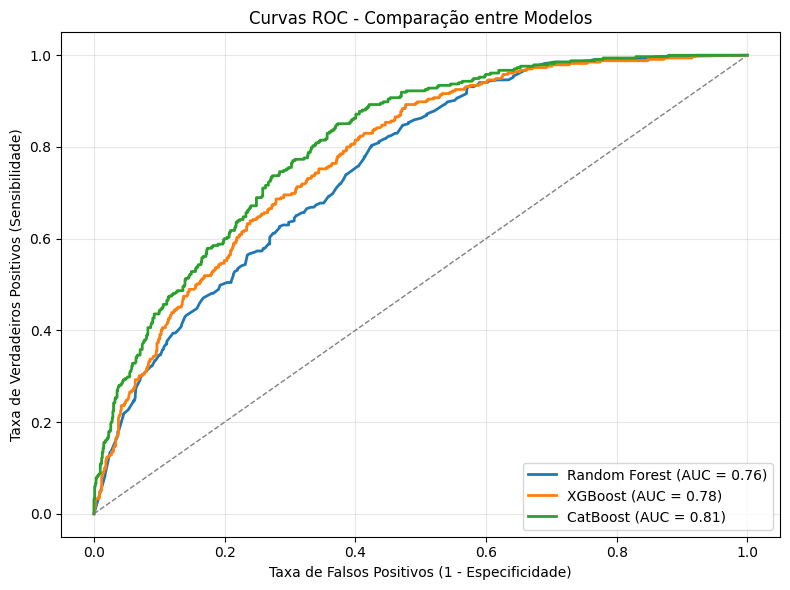


=== AUC por Modelo ===
Random Forest: 0.757
XGBoost: 0.780
CatBoost: 0.810


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Dicionário de cores e estilos para os modelos
colors = {
    'Random Forest': 'tab:blue',
    'XGBoost': 'tab:orange',
    'CatBoost': 'tab:green'
}

roc_results = {}

plt.figure(figsize=(8, 6))
for nome, modelo in modelos.items():
    # Probabilidades de churn (classe 1)
    y_proba = modelo.predict_proba(X_test)[:, 1]
    
    # Calcula curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Armazena resultados
    roc_results[nome] = roc_auc
    
    # Plota curva ROC
    plt.plot(fpr, tpr, color=colors[nome], lw=2, label=f"{nome} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

plt.title("Curvas ROC - Comparação entre Modelos")
plt.xlabel("Taxa de Falsos Positivos (1 - Especificidade)")
plt.ylabel("Taxa de Verdadeiros Positivos (Sensibilidade)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== AUC por Modelo ===")
for nome, valor in roc_results.items():
    print(f"{nome}: {valor:.3f}")


CatBoost (AUC = 0.810):
É o melhor entre os três. Isso significa que ele tem maior capacidade de separar corretamente clientes que vão churnar dos que vão permanecer.
XGBoost (AUC = 0.780):
Também performa bem, mas um pouco abaixo do CatBoost. Ainda assim, é um modelo competitivo.
Random Forest (AUC = 0.757):
Tem o menor AUC, indicando menor eficácia comparada aos demais, mas ainda aceitável.

Um AUC de 0.81 significa que, dado um cliente que churnou e outro que não, o modelo tem 81% de chance de classificar corretamente quem é quem.
Se o foco for performance preditiva bruta, o CatBoost é o modelo preferido nesse cenário.